## Sérsic Profile MCMCs for DES redMaGiC Elliptical Galaxies

### Aidan Cloonan

### October 2021

New notebook. Insert an explanation of the Bayesian statistics and purpose here. Something about constructing confidence intervals for fit parameters.

Model Function:

$$I(\mathbf{v}) = I_e \exp{\left\{-b_n \left[ \left( \frac{r}{R_e} \right)^{1/n} - 1 \right] \right\}}$$

where $b_n$ is defined such that the following is true:

$$\Gamma(2n) = 2\gamma(2n, b_n), \quad \rm{or}$$

$$\int_0^{\infty} x^{2n-1} e^{-x}\,dx = 2\int_0^{b_n} x^{2n-1} e^{-x}\,dx$$

$$\Gamma(2n) = \int_0^{\infty} x^{2n-1} e^{-x}\,dx \quad, \quad \gamma(2n, b_n) = \int_0^{b_n} x^{2n-1} e^{-x}\,dx$$

In [2]:
# math, array manipulation, etc.
import numpy as np

# timing
from timeit import default_timer

import astropy.io.fits as fits
from astropy.table import Table                    # Table data structure
import astropy.units as u

# necessary utilities from scipy, astropy and photutils
from scipy.optimize import differential_evolution
from scipy.ndimage import maximum_filter
from astropy.modeling import functional_models
from photutils import background

# plots
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

#%matplotlib inline

# MCMC sampling package
import emcee

import os

import sys

from photutils.background import Background2D
from astropy.stats import SigmaClip
from photutils.background import StdBackgroundRMS
from photutils.segmentation import deblend_sources
from photutils.segmentation import SegmentationImage

from astropy.convolution import Gaussian2DKernel
from astropy.stats import gaussian_fwhm_to_sigma
from photutils.segmentation import detect_sources

In [3]:
sys.path.append('/Users/aidan/Desktop/sl_project/galaxy-galaxy-sel/')

from imfit_mcmc import SersicMCMC

In [4]:
# the following commands make plots look better
def plot_prettier(dpi=200, fontsize=10): 
    plt.rcParams['figure.dpi']= dpi
    plt.rc("savefig", dpi=dpi)
    plt.rc('font', size=fontsize)
    plt.rc('xtick', direction='in')
    plt.rc('ytick', direction='in')
    plt.rc('xtick.major', pad=5) 
    plt.rc('xtick.minor', pad=5)
    plt.rc('ytick.major', pad=5) 
    plt.rc('ytick.minor', pad=5)
    plt.rc('lines', dotted_pattern = [2., 2.])
    # if you don't have LaTeX installed on your laptop and this statement 
    # generates error, comment it out
    plt.rc('text', usetex=True)
    
plot_prettier()

In [5]:
def read_fits_table(filename):
    '''
    reads and returns data in a table from a FITS file
    '''
    hdu = fits.open(filename)
    data = Table(hdu[1].data)   # second index of the hdu corresponds to the data in my astropy table files
    hdu.close()
    
    return data

def read_fits_image(filename):
    '''
    reads and returns an image from a FITS file
    '''
    hdu = fits.open(filename)
    data = hdu[0].data
    header = hdu[0].header 
    hdu.close()
    
    return data

def get_files(path):
    files = np.array(os.listdir(path))
    finds = [i for i, f in enumerate(files) if '.fits' in f]
    files = files[finds]
    return files

In [6]:
def ellipticity2theta_q(e1, e2):
    """
    transforms complex ellipticity moduli in orientation angle and axis ratio

    :param e1: eccentricity in x-direction
    :param e2: eccentricity in xy-direction
    :return: 1 - axis ratio (minor/major), angle in radian
    """
        
    theta = np.arctan2(e2, e1)/2
        
    c = np.sqrt(e1**2+e2**2)
    c = np.minimum(c, 0.9999)
        
    q = (1-c)/(1+c)
        
    return 1 - q, theta

def get_img_uncertainties(img, num=1.0):
    '''
    a function that estimates uncertainties in the pixel values of redmagic 
    images, both from background and from the elliptical galaxy
    
    also returns the grid of I_gal values, which is what the Sérsic model is fit to
    
    inputs:
    --------
    
    img        ---    2D array; a DES redMaGiC image with an elliptical galaxy that a Sérsic
                      model is being fit to  
    
    outputs:
    --------
    
    img_gal    ---    2D array; alternatively img_gal_copy (explained below); the grid of I_gal values
                      calculated from estimation of a constant I_bg
    
    std_arr    ---    2D array; grid of uncertainties in corresponding pixel values from the DES image
                      
    
    PSEUDOCODE:
    
    get background and galaxy pixels as before
    
    I_bg = np.mean(bg_pixels)
    
    sigma_bg = root mean square of bg_pixels
    
    I_gal = I_tot - I_bg
    
    sigma_gal = np.sqrt(I_gal)
    
    invalid_sgal_ind = where sigma_gal is inf or nan
    
    sigma_gal[invalid_sgal_ind] = 0
    
    sigma_tot = np.sqrt(sigma_bg**2 + sigma_gal**2)
    
    return I_gal, sigma_tot
    
    '''
    
    sigma_clip = SigmaClip(sigma=3.0, maxiters=10)
    
    bg_pixels = sigma_clip(img, masked=False, axis=None)
    
    ## I_bg and std_bg
    
    img_bg = np.mean(bg_pixels)  # I_bg
    
    bkgrms = StdBackgroundRMS(sigma_clip)
    std_bg = bkgrms(img) 
    
    ## I_gal
    
    img_gal = img - img_bg          # I_tot = I_gal + I_bg
    
    std_gal = np.sqrt(num * img_gal) 
    
    invalid_sgal_ind = (std_gal == np.inf) | (std_gal == -np.inf)
    std_gal[invalid_sgal_ind] = 0
    
    std_gal = np.nan_to_num(std_gal)
    
    ## estimate uncertainties

    std_arr = np.sqrt(std_gal**2 + std_bg**2)

    return img_gal, std_arr

def chi2_sersic(v, *args):
    
    ar, rr, nr, ag, rg, ng, x0, y0, e1, e2 = v
    npar = len(v)
        
    e, th = ellipticity2theta_q(e1, e2)
    
    img_gal_r = args[0]; img_gal_g = args[1]
    stds_r = args[2]; stds_g = args[3]
    
    nrow, ncol = img_gal_r.shape
    xgrid, ygrid = np.meshgrid(np.arange(ncol), np.arange(nrow))
    
    ## initialize Sersic profiles
        
    # r-band
    model_r = functional_models.Sersic2D(amplitude=ar, r_eff=rr, n=nr
                                         , x_0=x0, y_0=y0
                                         , ellip=e, theta=th)
        
    profile_r = model_r(xgrid, ygrid)
        
    # g-band
    model_g = functional_models.Sersic2D(amplitude=ag, r_eff=rg, n=ng
                                         , x_0=x0, y_0=y0
                                         , ellip=e, theta=th)
        
    profile_g = model_g(xgrid, ygrid)
        
    # calculate E^2, sum of squared errors
    pchi2 = ((img_gal_r - profile_r) / stds_r)**2 + ((img_gal_g - profile_g) / stds_g)**2
        
    ### How do I incorporate the g-band into this new formulation?
    
    e2 = np.sum(pchi2)
    norm = pchi2.size - npar
    
    # reduced chi2
    redchi2 = e2 / norm
    
    return redchi2
    
def chi2_minimize(img_gal_r, img_gal_g, stds_r, stds_g, dtypes=None, npop=25):
    '''
    minimizes the chi2 function defined above using a 
    differential evolution algorithm imported from scipy
        
    change to likelihood
    '''
    
    # define args, bounds
    args = [img_gal_r, img_gal_g, stds_r, stds_g]
        
    nrow, ncol = img_gal_r.shape
    
    # bounds
    amin, amax = 1e-3, 300;
    rmin, rmax = 1e-3, 15;
    nmin, nmax = 1e-3, 8;
    x0min, x0max = ncol/2 - 3, ncol/2 + 3;
    y0min, y0max = nrow/2 - 3, nrow/2 + 3;
    e1min, e1max = -0.5, 0.5;
    e2min, e2max = -0.5, 0.5
    
    bounds = np.array([(amin, amax), (rmin, rmax), (nmin, nmax)
                        , (amin, amax), (rmin, rmax), (nmin, nmax)
                        , (x0min, x0max), (y0min, y0max)
                        , (e1min, e1max), (e2min, e2max)])
        
    ar0 = amin + (amax - amin) * np.random.uniform(0,1, size=npop)
    rr0 = rmin + (rmax - rmin) * np.random.uniform(0,1, size=npop)
    nr0 = nmin + (nmax - nmin) * np.random.uniform(0,1, size=npop)
    
    ag0 = amin + (amax - amin) * np.random.uniform(0,1, size=npop)
    rg0 = rmin + (rmax - rmin) * np.random.uniform(0,1, size=npop)
    ng0 = nmin + (nmax - nmin) * np.random.uniform(0,1, size=npop)
    
    x0 = (ncol / 2) * np.random.uniform(0.8, 1.2, size=npop)
    y0 = (nrow / 2) * np.random.uniform(0.8, 1.2, size=npop)
    e10 = e1min + (e1max - e1max) * np.random.uniform(0,1, size=npop)
    e20 = e2min + (e2max - e2min) * np.random.uniform(0,1, size=npop)
        
    v0 = np.column_stack((ar0, rr0, nr0               # r-band
                          , ag0, rg0, ng0             # g-band
                          , x0, y0, e10, e20       
                         ))
        
    tstart = default_timer()
        
    run = differential_evolution(chi2_sersic, popsize=npop, tol = 1e-4
                                     , bounds=bounds, args=args
                                     , init = v0
                                    )
    
    print("completed in {:>.5g} sec".format(default_timer() - tstart))
    print("minimum at:",run.x)
    print('f =', run.fun)
    
    return run.x

'''
def chi2_sersic(v, *args):
    
    a, r, n, x0, y0, e, th = v
    npar = len(v)
    
    # args is the grid of I_gal values and grid of uncertainties
    #print(args[0][0])
    img_gal = args[0]; stds = args[1]
    nrow, ncol = img_gal.shape
    xgrid, ygrid = np.meshgrid(np.arange(ncol), np.arange(nrow))
    
    # initialize Sersic profile
    model = functional_models.Sersic2D(amplitude=a, r_eff=r, n=n
                                         , x_0=x0, y_0=y0
                                         , ellip=e, theta=th)
    profile = model(xgrid, ygrid)
    
    pchi2 = ((img_gal - profile) / stds)**2
    
    # E^2, sum of squared errors
    e2 = np.sum(pchi2)
    norm = pchi2.size - npar
    
    # reduced chi2
    redchi2 = e2 / norm
    
    return redchi2

def chi2_minimize(img_gal, stds, dtypes=None, npop=25):
        
    # define args, bounds
    args = [img_gal, stds]
        
    nrow, ncol = img_gal.shape

    # bounds
    amin, amax = 1e-3, 300;
    rmin, rmax = 1e-3, 15;
    nmin, nmax = 1e-3, 8;
    x0min, x0max = ncol/2 - 3, ncol/2 + 3;
    y0min, y0max = nrow/2 - 3, nrow/2 + 3;
    e1min, e1max = -0.5, 0.5;
    e2min, e2max = -0.5, 0.5
    
    bounds = np.array([(amin, amax), (rmin, rmax), (nmin, nmax)
                        , (x0min, x0max), (y0min, y0max)
                        , (e1min, e1max), (e2min, e2max)])
        
    a0 = amin + (amax - amin) * np.random.uniform(0,1, size=npop)
    r0 = rmin + (rmax - rmin) * np.random.uniform(0,1, size=npop)
    n0 = nmin + (nmax - nmin) * np.random.uniform(0,1, size=npop)
    x0 = (ncol / 2) * np.random.uniform(0.8, 1.2, size=npop)
    y0 = (nrow / 2) * np.random.uniform(0.8, 1.2, size=npop)
    e10 = e1min + (e1max - e1max) * np.random.uniform(0,1, size=npop)
    e20 = e2min + (e2max - e2min) * np.random.uniform(0,1, size=npop)
        
    v0 = np.column_stack((a0, r0, n0, x0, y0, e10, e20))
        
    tstart = default_timer()
        
    run = differential_evolution(chi2_sersic, popsize=npop, tol = 1e-4
                                 , bounds=bounds, args=args
                                 , init = v0
                                )
    
    print("completed in {:>.5g} sec".format(default_timer() - tstart))
    print("minimum at:",run.x)
    print('f =', run.fun)
    
    return run.x
'''

'\ndef chi2_sersic(v, *args):\n    \n    a, r, n, x0, y0, e, th = v\n    npar = len(v)\n    \n    # args is the grid of I_gal values and grid of uncertainties\n    #print(args[0][0])\n    img_gal = args[0]; stds = args[1]\n    nrow, ncol = img_gal.shape\n    xgrid, ygrid = np.meshgrid(np.arange(ncol), np.arange(nrow))\n    \n    # initialize Sersic profile\n    model = functional_models.Sersic2D(amplitude=a, r_eff=r, n=n\n                                         , x_0=x0, y_0=y0\n                                         , ellip=e, theta=th)\n    profile = model(xgrid, ygrid)\n    \n    pchi2 = ((img_gal - profile) / stds)**2\n    \n    # E^2, sum of squared errors\n    e2 = np.sum(pchi2)\n    norm = pchi2.size - npar\n    \n    # reduced chi2\n    redchi2 = e2 / norm\n    \n    return redchi2\n\ndef chi2_minimize(img_gal, stds, dtypes=None, npop=25):\n        \n    # define args, bounds\n    args = [img_gal, stds]\n        \n    nrow, ncol = img_gal.shape\n\n    # bounds\n    amin, ama

### Testing Masking Function

From <tt>photutils</tt>, tested on 10 images from DES Y3 redMaGiC catalog.

In [8]:
jr_path = '/Users/aidan/Desktop/sl_project/img_cutouts/sl_jacobs/rband_dr2/no_cluster_scale/mask_works/fit_works/'
jg_path = '/Users/aidan/Desktop/sl_project/img_cutouts/sl_jacobs/gband_dr2/no_cluster_scale/mask_works/fit_works/'

files = np.array(os.listdir(jr_path))
finds = [i for i, f in enumerate(files) if 'DESJ' in f]
files_r = files[finds]

files = np.array(os.listdir(jg_path))
finds = [i for i, f in enumerate(files) if 'DESJ' in f]
files_g = files[finds]
#print(files)

In [24]:
test_img_r = read_fits_image(os.path.join(jr_path, files_r[1]))
test_img_g = read_fits_image(os.path.join(jg_path, files_g[1]))
#test_img_r = read_fits_image('/Users/aidan/Downloads/DESJ031253.9220-130825.4832_r.fits')
#test_img_g = read_fits_image('/Users/aidan/Downloads/DESJ031253.9220-130825.4832_g.fits')

#desid = 'DES04500-57'
desid = 'DESJ0103-43'

nrow, ncol = test_img_r.shape
print(nrow, ncol)


71 71


In [14]:
# calculate std of PSF

fwhm_r = 0.95 * u.arcsec
fwhm_g = 1.11 * u.arcsec

# length of one side of the image
length = 0.31 * u.arcmin

# arcsec per pixel
arcsec_pix = 0.263

test_arr = np.zeros_like(test_img_r)
all_inds = np.argwhere(test_arr == 0)

dist2cent = np.linalg.norm(all_inds - (np.array([nrow, ncol])-1)/2, axis=1).reshape(nrow, ncol)
print((np.array([nrow, ncol])-1)/2)

fwhm_pix_r = fwhm_r.value / arcsec_pix
fwhm_pix_g = fwhm_g.value / arcsec_pix

#print(fwhm_pix_r, fwhm_pix_g)

std_psf_r = fwhm_pix_r / (2 * np.sqrt(2 * np.log(2)))
std_psf_g = fwhm_pix_g / (2 * np.sqrt(2 * np.log(2)))

[35. 35.]


In [14]:
test = SersicMCMC(img_r = test_img_r, img_g = test_img_g
                  , std_psf_r = std_psf_r, std_psf_g = std_psf_g
                  , desid = desid, num=2)

/Users/aidan/Desktop/sl_project/des-sl-selection/sersic_mcmc_pipeline_acloonan.py:177: RuntimeWarning: invalid value encountered in sqrt
  std_gal = np.sqrt(num * img_gal)
/Users/aidan/Desktop/sl_project/des-sl-selection/sersic_mcmc_pipeline_acloonan.py:177: RuntimeWarning: invalid value encountered in sqrt
  std_gal = np.sqrt(num * img_gal)


In [10]:
run, dist = test.mcmc_run()
    
test.plot_trace()
#test.plot_gal()

/Users/aidan/Desktop/sl_project/des-sl-selection/sersic_mcmc_pipeline_acloonan.py:177: RuntimeWarning: invalid value encountered in sqrt
  std_gal = np.sqrt(num * img_gal)
/Users/aidan/Desktop/sl_project/des-sl-selection/sersic_mcmc_pipeline_acloonan.py:177: RuntimeWarning: invalid value encountered in sqrt
  std_gal = np.sqrt(num * img_gal)


completed in 306.56 sec
minimum at: [ 9.82310194e+01  3.09475628e+00  1.23145070e+00  2.39495314e+01
  3.21074323e+00  9.84589314e-01  3.42100037e+01  3.47329186e+01
 -8.89634496e-03  2.17465785e-02]
f = 0.7740563242766714


 15%|█▌        | 191/1250 [05:13<32:24,  1.84s/it]Traceback (most recent call last):
  File "/Users/aidan/opt/anaconda3/lib/python3.7/site-packages/emcee/ensemble.py", line 624, in __call__
    return self.f(x, *self.args, **self.kwargs)
  File "/Users/aidan/Desktop/sl_project/des-sl-selection/sersic_mcmc_pipeline_acloonan.py", line 427, in log_posterior
    loglike = self.log_likelihood(v)
  File "/Users/aidan/Desktop/sl_project/des-sl-selection/sersic_mcmc_pipeline_acloonan.py", line 405, in log_likelihood
    norm_profile_g = convolve(norm_profile_g, self.psf_r)
  File "/Users/aidan/opt/anaconda3/lib/python3.7/site-packages/astropy/nddata/decorators.py", line 246, in wrapper
    result = func(data, *args, **kwargs)
  File "/Users/aidan/opt/anaconda3/lib/python3.7/site-packages/astropy/convolution/convolve.py", line 335, in convolve
    n_threads)
KeyboardInterrupt
 15%|█▌        | 191/1250 [05:13<29:00,  1.64s/it]
ERROR:root:Internal Python error in the inspect module.
Below is the 

emcee: Exception while calling your likelihood function:
  params: [ 3.03394899e+00  1.22526464e+00  3.22628938e+00  9.99982271e-01
  3.42749178e+01  3.47421248e+01 -1.19763521e-02  1.83631431e-02]
  args: []
  kwargs: {}
  exception:
Traceback (most recent call last):
  File "/Users/aidan/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-10-dbf2052b7dbf>", line 4, in <module>
    run, dist = test.mcmc_run()
  File "/Users/aidan/Desktop/sl_project/des-sl-selection/sersic_mcmc_pipeline_acloonan.py", line 448, in mcmc_run
    sampler.run_mcmc(pr, steps, progress=True)
  File "/Users/aidan/opt/anaconda3/lib/python3.7/site-packages/emcee/ensemble.py", line 443, in run_mcmc
    for results in self.sample(initial_state, iterations=nsteps, **kwargs):
  File "/Users/aidan/opt/anaconda3/lib/python3.7/site-packages/emcee/ensemble.py", line 402, in sample
    state, accep

KeyboardInterrupt: 

----------------------------



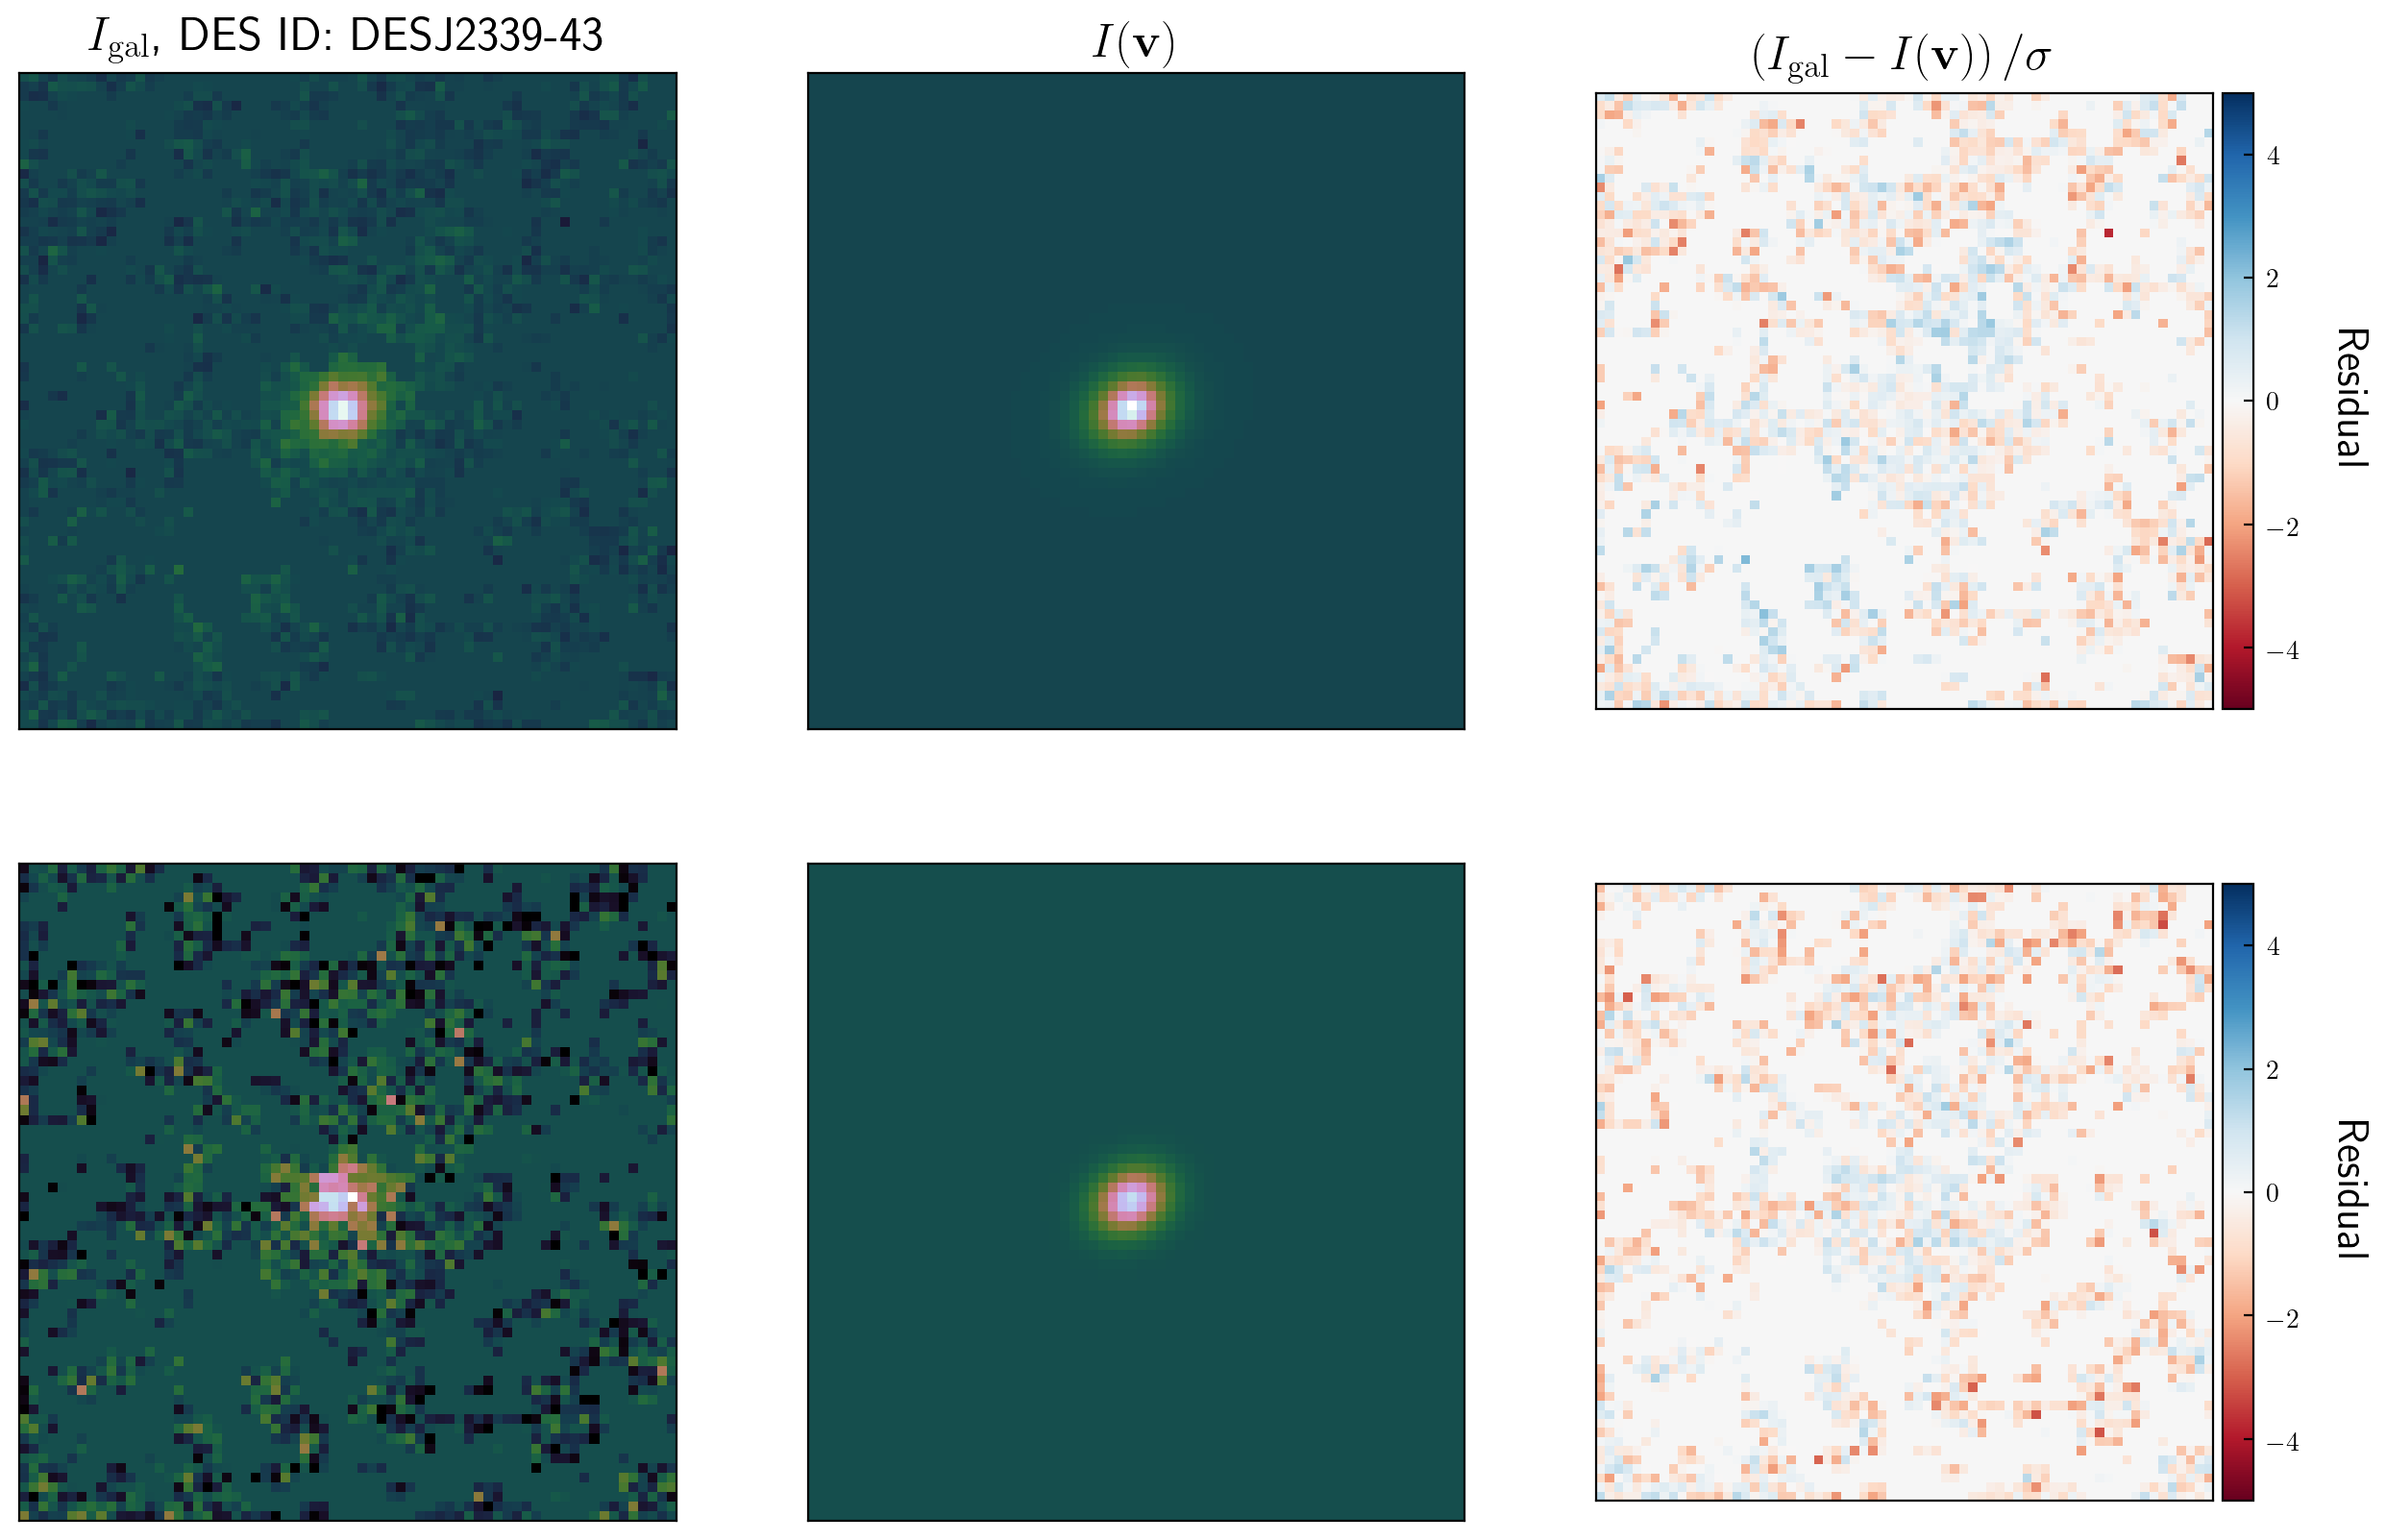

In [8]:
test.plot_gal(height=10, width=15, num_r=10, num_g=-2)

45.72652
306.44205


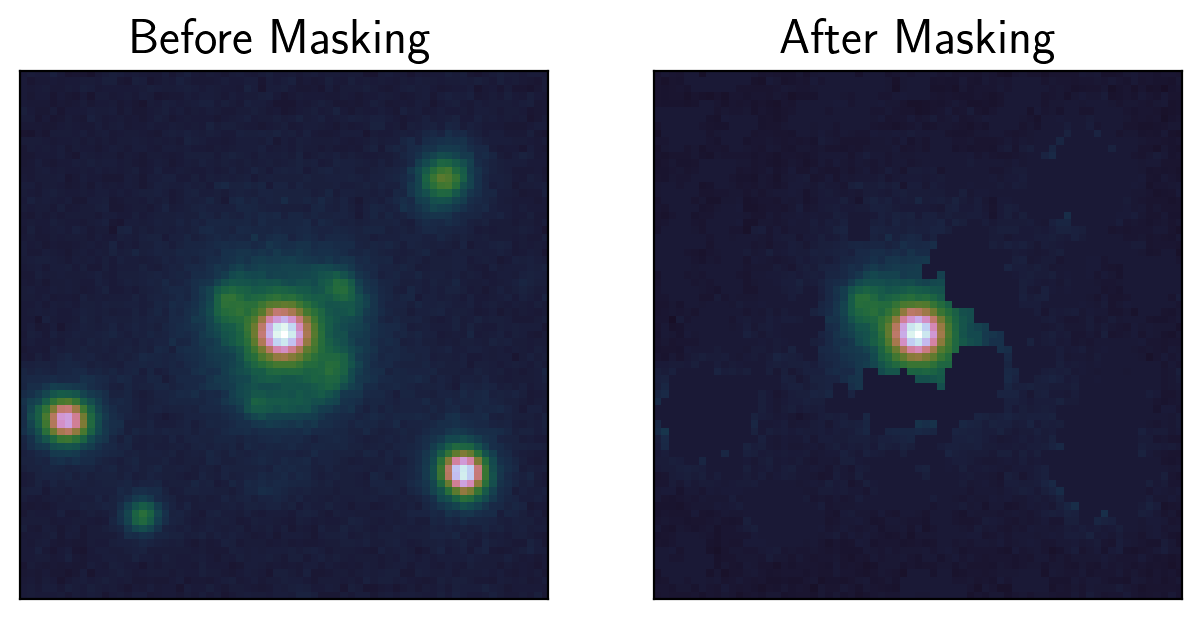

In [15]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7.5, 4.5))
print(test.img_gal_g.max())
print(test.img_gal_r.max())
ax1.imshow(test.img_r, origin='lower', cmap='cubehelix', interpolation='nearest', vmin=-40, vmax=np.max(test.img_gal_r))
ax1.set_title('Before Masking', fontsize=18)
ax2.imshow(test.img_gal_r, origin='lower', cmap='cubehelix', interpolation='nearest', vmin=-40, vmax=np.max(test.img_gal_r))
ax2.set_title('After Masking', fontsize=18)

# Hide axes ticks
for ax in (ax1, ax2):
    ax.set_xticks([])
    ax.set_yticks([])

In [14]:
def create_mask(img, img_r, num=3):
    '''
    Takes a raw input fits image and constructs a mask to filter out light 
    from other sources apart from the lens/galaxy. Returns the masked image,
    where pixel values from other sources are set to 0.
    
    '''

    # construct a background image w/ background noise
    bkg = Background2D(img, box_size=5)
    bkg_img = bkg.background
    
    # calculate RMS of each pixel, used to calculate threshold for source identification
    sigma_clip = SigmaClip(sigma=3.0, maxiters=10)
    bkgrms = StdBackgroundRMS(sigma_clip)
    bkgrms_img = bkgrms(img) 

    # map of thresholds over which sources are detected
    threshold = bkg_img + (0.5 * bkgrms_img)  
    
    # source detection
    sigma = 3.0 * gaussian_fwhm_to_sigma  # FWHM = 3.
    kernel = Gaussian2DKernel(sigma, x_size=3, y_size=3).normalize()
    segm = detect_sources(img, threshold, 5, kernel)
    
    # deblending sources, looking for saddles between peaks in flux
    segm_deblend = deblend_sources(img, segm, npixels=5,
                                   nlevels=32, contrast=0.001)
    
    label = segm_deblend.data[(segm_deblend.data.shape[0]//2, segm_deblend.data.shape[1]//2)]
    other_inds = np.delete(np.arange(1, segm_deblend.nlabels+1), label-1)
    
    deblend_copy = segm_deblend.data.copy()
    source = (deblend_copy == label)
    
    # get pixels from all other sources
    segm_deblend.keep_labels(other_inds)

    segm_dilated_arr = maximum_filter(segm_deblend.data, num)
    segm_dilated_arr[segm_deblend.data != 0] = segm_deblend.data[segm_deblend.data != 0]
        
    # label central source, which is the lens/galaxy
    segm_dilated_arr[source] = 1000
    
    segm_dilated = SegmentationImage(segm_dilated_arr)
    
    other_inds = np.delete(segm_dilated.labels, -1)
        
    # get pixels from all other sources
    segm_dilated.keep_labels(other_inds)
    
    nonzeros = (segm_dilated.data > 0)

    # make values of those pixels 0
    real_test = img.copy()
    real_test[nonzeros] = 0
    
    # get uncertainties and estimate lens/galaxy data to fit a quick profile
    test_gal_g, test_stds_g = get_img_uncertainties(img)
    test_gal_r, test_stds_r = get_img_uncertainties(img_r)
    
    #test_v = chi2_minimize(test_gal_r, test_gal_g, test_stds_r, test_stds_g)
    
    #ar, rr, nr, ag, rg, ng, x0, y0, e, th = test_v
    #model = functional_models.Sersic2D(amplitude=ag, r_eff=rg, n=ng
    #                                     , x_0=x0, y_0=y0
    #                                     , ellip=e, theta=th)

    nrow, ncol = test_gal_g.shape
    xgrid, ygrid = np.meshgrid(np.arange(ncol), np.arange(nrow))
    #profile = model(xgrid, ygrid)

    #cl_residual = (real_test - profile) / test_stds_g

    # ignore pixels which have already been filtered out
    #cl_residual[nonzeros] = np.nan

    # create a small mask which filters out pixels beyond 3sigma in residual map
    #sigma_clip = SigmaClip(sigma=3, maxiters=10)
    #cl_mask = sigma_clip(cl_residual)

    # turn those into 0s
    new_test = real_test.copy()
    #new_test[cl_mask.mask] = 0
    
    img_r[nonzeros] = 0
    
    return new_test, img_r

In [26]:
#test_img_g = read_fits_image(os.path.join(jg_path, 'DESJ012753.1792-453233.8640_g.fits'))
#test_img_r = read_fits_image(os.path.join(jr_path, 'DESJ012753.1792-453233.8640_r.fits'))

#test_img_g = read_fits_image(os.path.join(jg_path, 'DESJ045008.8080-571520.0160_g.fits'))
#test_img_r = read_fits_image(os.path.join(jr_path, 'DESJ045008.8080-571520.0160_r.fits'))

mask_test_g, mask_test_r = create_mask(test_img_g, test_img_r, num=1)

# alright, so it's working. now figure out how to get result from object methods to work the same

100%|██████████████████████████████████████████| 29/29 [00:00<00:00, 217.93it/s]
/var/folders/w0/42nt1p3j6szgcznjn4btwmwm0000gn/T/ipykernel_86092/860768215.py:78: RuntimeWarning: invalid value encountered in sqrt
  std_gal = np.sqrt(num * img_gal)
/var/folders/w0/42nt1p3j6szgcznjn4btwmwm0000gn/T/ipykernel_86092/860768215.py:78: RuntimeWarning: invalid value encountered in sqrt
  std_gal = np.sqrt(num * img_gal)


Text(0.5, 1.0, 'After')

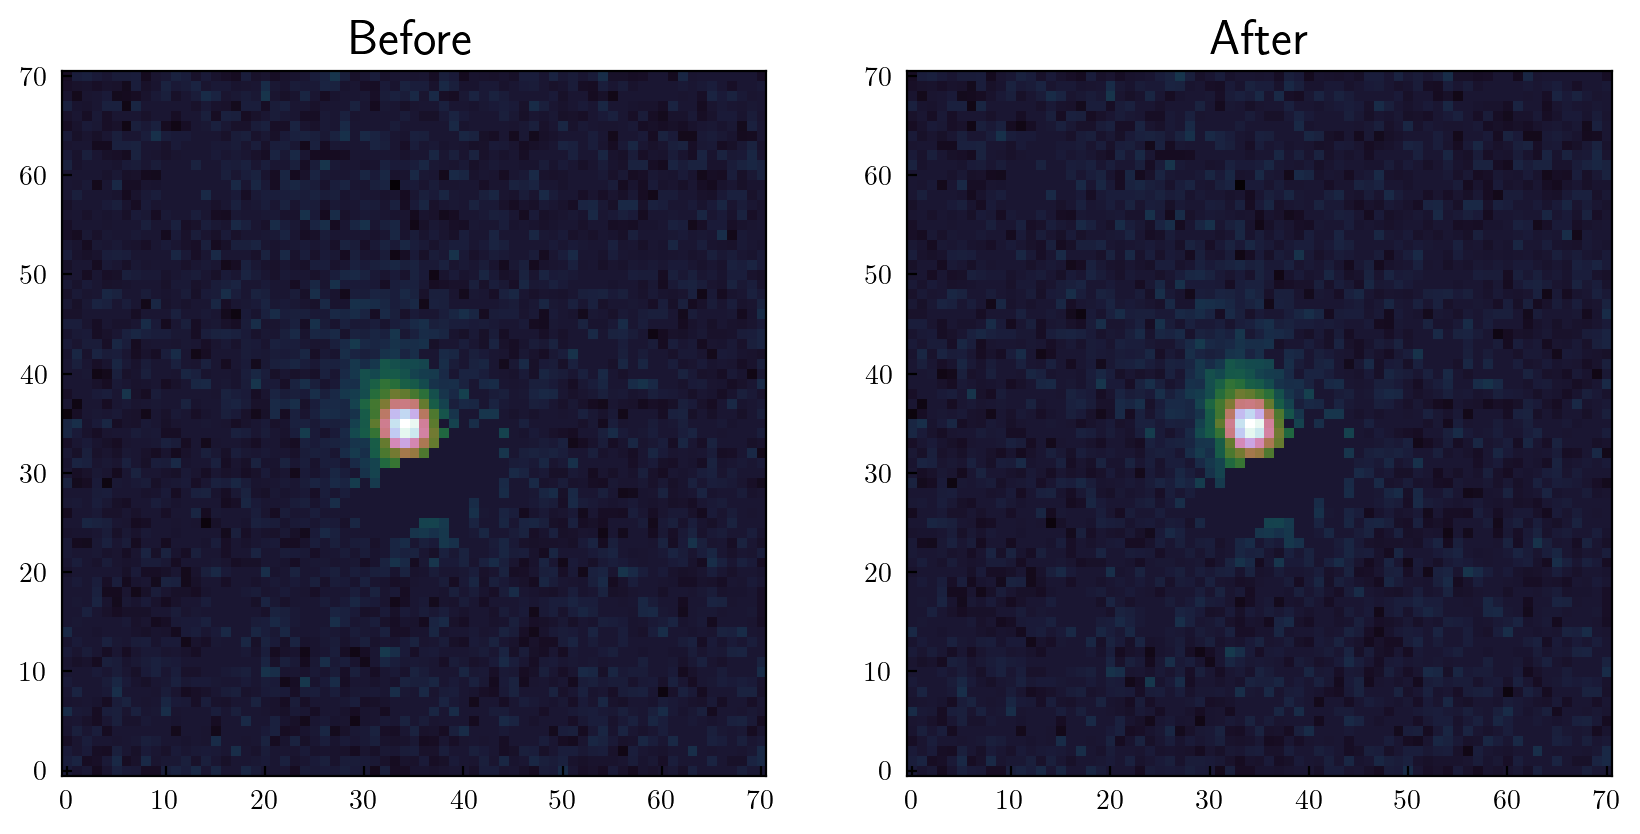

In [27]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6))
ax1.imshow(test_img_r, origin='lower', cmap='cubehelix', interpolation='nearest', vmin=-10, vmax=np.max(test_img_r))
ax1.set_title('Before', fontsize=18)
ax2.imshow(mask_test_r, origin='lower', cmap='cubehelix', interpolation='nearest', vmin=-10, vmax=np.max(test_img_r))
ax2.set_title('After', fontsize=18)

Now run MCMC.

In [28]:
desid = 'DESJ001030'

test = SersicMCMC(new_test, desid)
run, dist = test.mcmc_run()
    
test.plot_trace()
test.plot_gal()


NameError: name 'new_test' is not defined

Below is a bunch of random testing. The function is above.

In [9]:
from photutils.background import Background2D
from astropy.stats import SigmaClip
from photutils.background import StdBackgroundRMS

index = 15
print(files[index])
test_sl_img = read_fits_image(os.path.join(jg_path, 'DESJ012753.1792-453233.8640_g.fits'))

bkg = Background2D(test_sl_img, box_size=5)
bkg_img = bkg.background

sigma_clip = SigmaClip(sigma=3.0, maxiters=10)
bkgrms = StdBackgroundRMS(sigma_clip)
bkgrms_img = bkgrms(test_sl_img) 

threshold = bkg_img + (0.5 * bkgrms_img)  

DESJ051012.7944-323205.7120_g.fits


In [21]:
from astropy.convolution import Gaussian2DKernel
from astropy.stats import gaussian_fwhm_to_sigma
from photutils.segmentation import detect_sources
from scipy import ndimage
sigma = 3.0 * gaussian_fwhm_to_sigma  # FWHM = 3.
kernel = Gaussian2DKernel(sigma, x_size=3, y_size=3)
kernel.normalize()
segm = detect_sources(test_sl_img, threshold, 5, kernel)

In [30]:
import scipy.ndimage as ndimage

A = np.array([[0, 0, 0, 0, 0, 0, 0, 0],
              [0, 1, 1, 2, 2, 0, 0, 0],
              [0, 1, 1, 2, 2, 0, 3, 3],
              [0, 0, 0, 0, 0, 0, 3, 3],
              [0, 0, 0, 0, 0, 0, 3, 3],
              [0, 0, 0, 0, 0, 0, 0, 0],
              [0, 0, 0, 0, 0, 0, 0, 0],
              [0, 0, 0, 0, 0, 0, 0, 0]])

B = ndimage.maximum_filter(segm.data, 3)
B[segm.data != 0] = segm.data[segm.data != 0]

print(B)

[[ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 ...
 [ 0  0  0 ... 22  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]]


Text(0.5, 1.0, 'Segmentation Image')

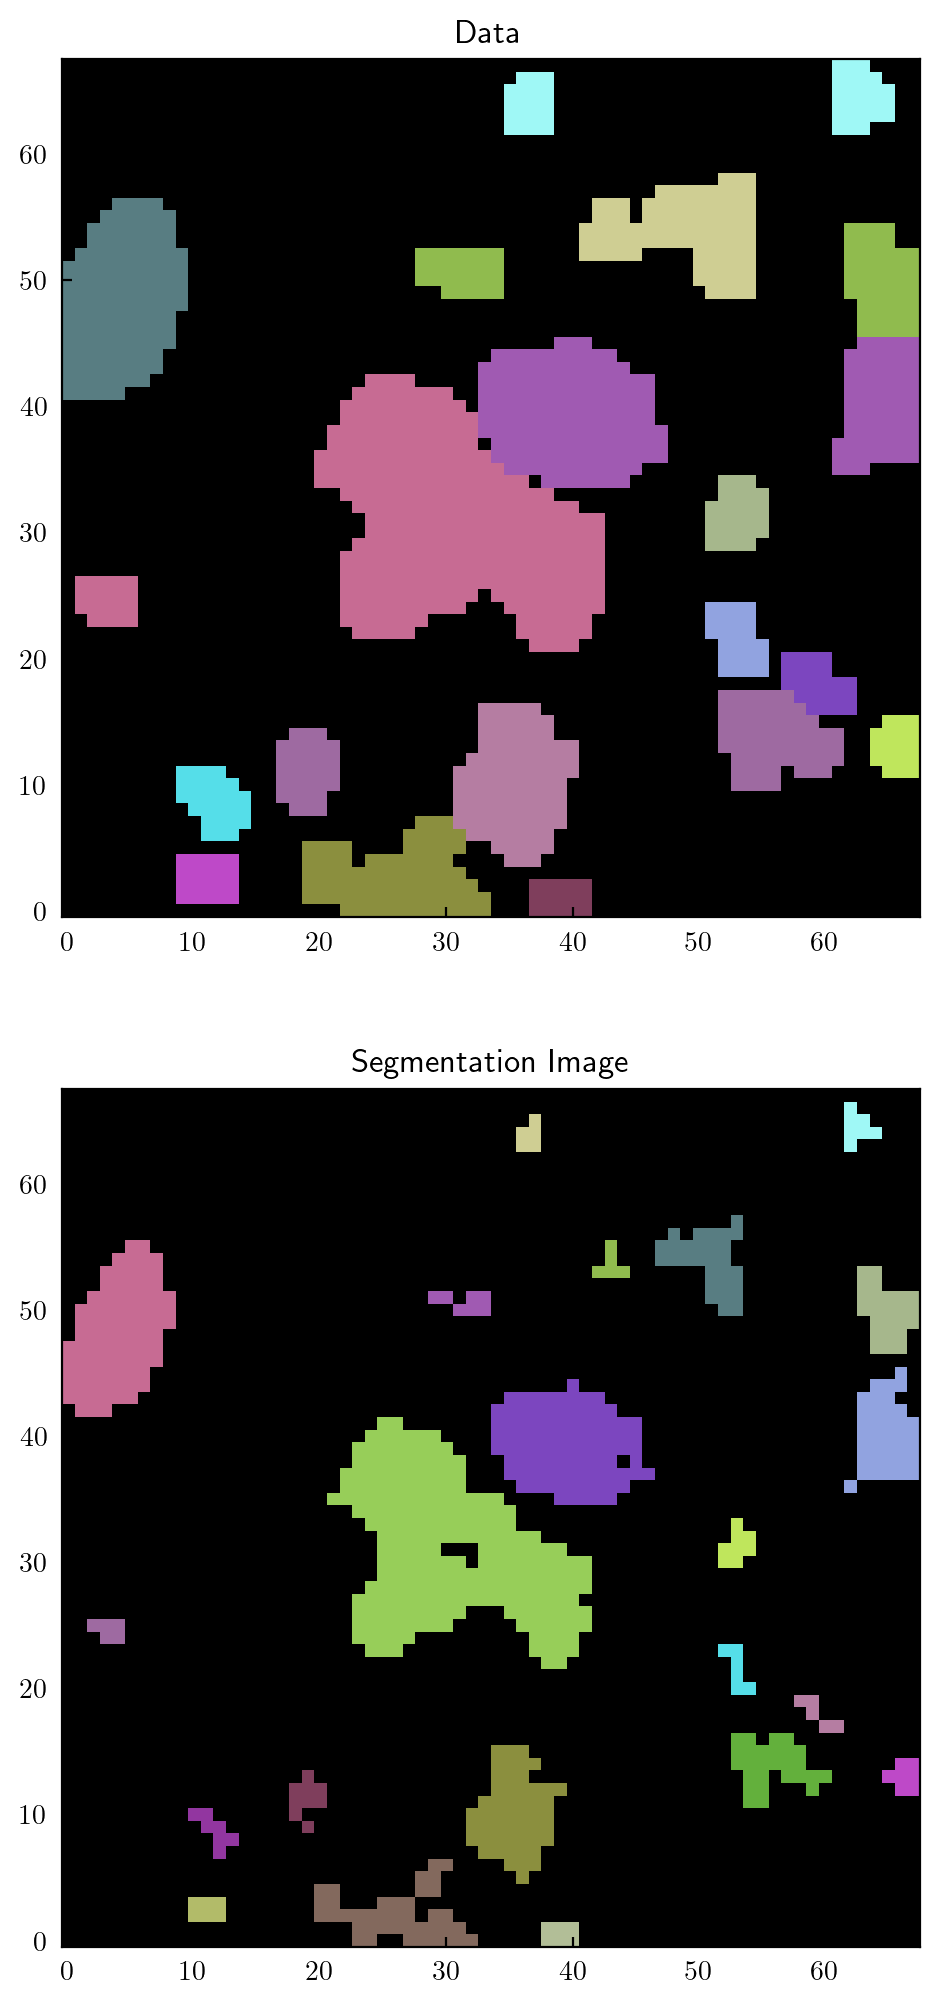

In [33]:
from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize
norm = ImageNormalize(stretch=SqrtStretch())
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12.5))
ax1.imshow(B, origin='lower', cmap=cmap, norm=norm)
ax1.set_title('Data')
cmap = segm.make_cmap(seed=123)
ax2.imshow(segm, origin='lower', cmap=cmap, interpolation='nearest')
ax2.set_title('Segmentation Image')

In [43]:
from photutils.segmentation import deblend_sources
from photutils.segmentation import SegmentationImage
segm_deblend = deblend_sources(test_sl_img, segm, npixels=5,
                               nlevels=32, contrast=0.001)

B = ndimage.maximum_filter(segm_deblend.data, 3)
B[segm_deblend.data != 0] = segm_deblend.data[segm_deblend.data != 0]

segm_deblend = SegmentationImage(B.copy())
print(segm_deblend.data)

[[ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 ...
 [ 0  0  0 ... 17  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]]


Text(0.5, 1.0, 'Segmentation Image')

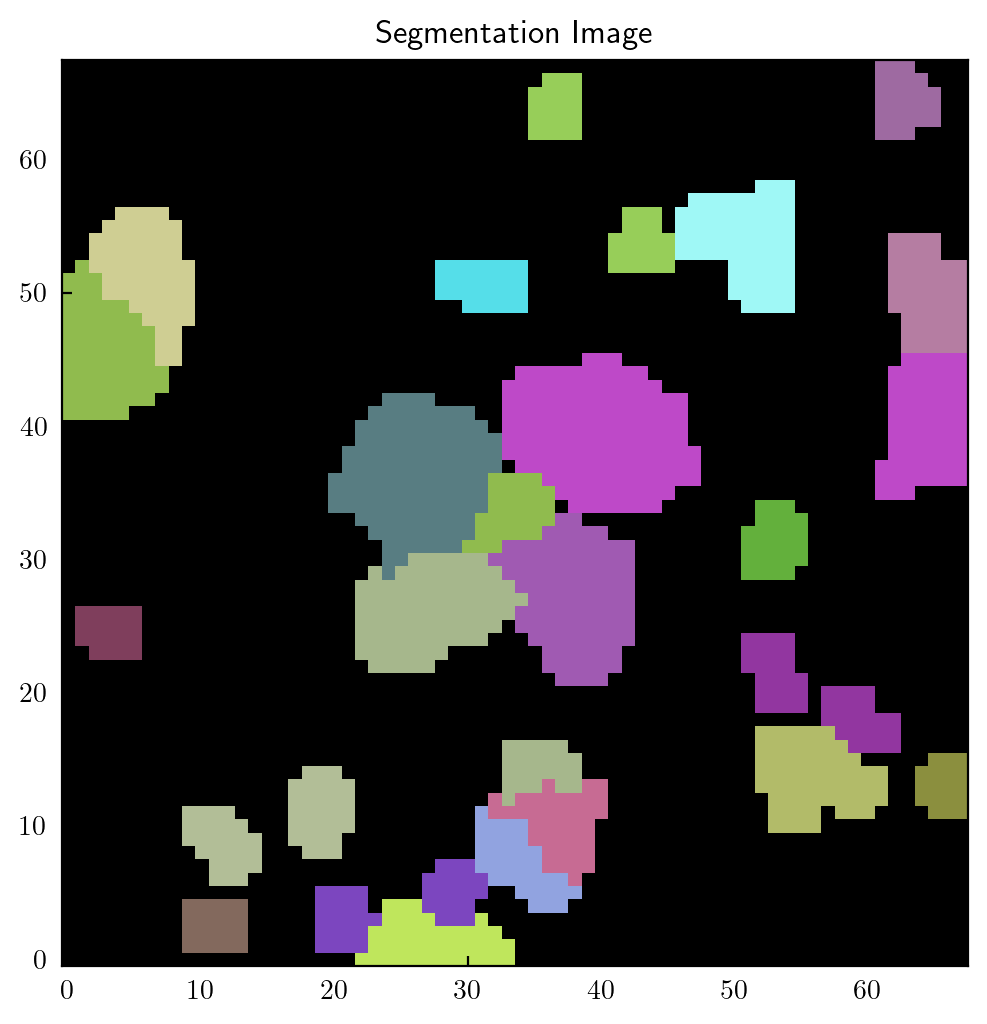

In [44]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.imshow(segm_deblend, origin='lower', cmap=cmap, interpolation='nearest')
ax.set_title('Segmentation Image')

In [45]:
label = segm_deblend.data[(segm.shape[0]//2, segm.shape[1]//2)]
test_inds = np.delete(np.arange(1, segm_deblend.nlabels+1), label-1)

segm_deblend_copy = segm_deblend.copy()
segm_deblend_copy.keep_labels(test_inds)

segm_deblend_gal = segm_deblend.copy()
segm_deblend_gal.keep_label(label)

In [46]:
nonzeros = (segm_deblend_copy.data > 0)
galnonzeros = (segm_deblend_gal.data > 0)

#clipping = test_sl_img.copy()
#clipping[nonzeros] = np.nan
#clipping[galnonzeros] = 0

#sigma_clip = SigmaClip(sigma=3.0, maxiters=10)
#cl_mask = sigma_clip(clipping)
#cl_mask.mask.shape, clipping.shape

real_test = test_sl_img.copy()
real_test[nonzeros] = 0
#real_test[cl_mask.mask] = 0


Text(0.5, 1.0, 'Segmentation Image')

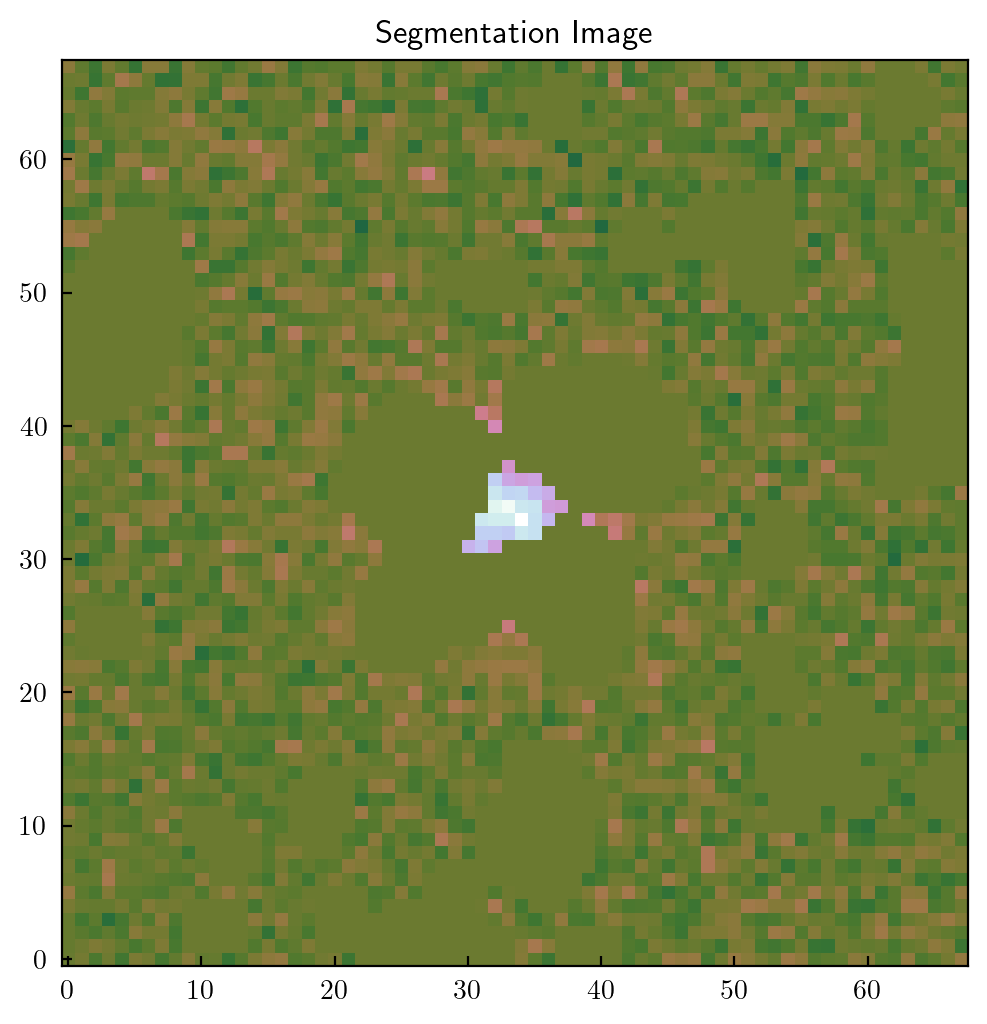

In [47]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.imshow(real_test, origin='lower', cmap='cubehelix', interpolation='nearest', vmin=-20, vmax=np.max(real_test))
ax.set_title('Segmentation Image')

In [48]:
real_test
test_gal, test_stds = get_img_uncertainties(real_test)
test_v = chi2_minimize(test_gal, test_stds)

/Users/aidan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:78: RuntimeWarning: invalid value encountered in sqrt


TypeError: chi2_minimize() missing 2 required positional arguments: 'stds_r' and 'stds_g'

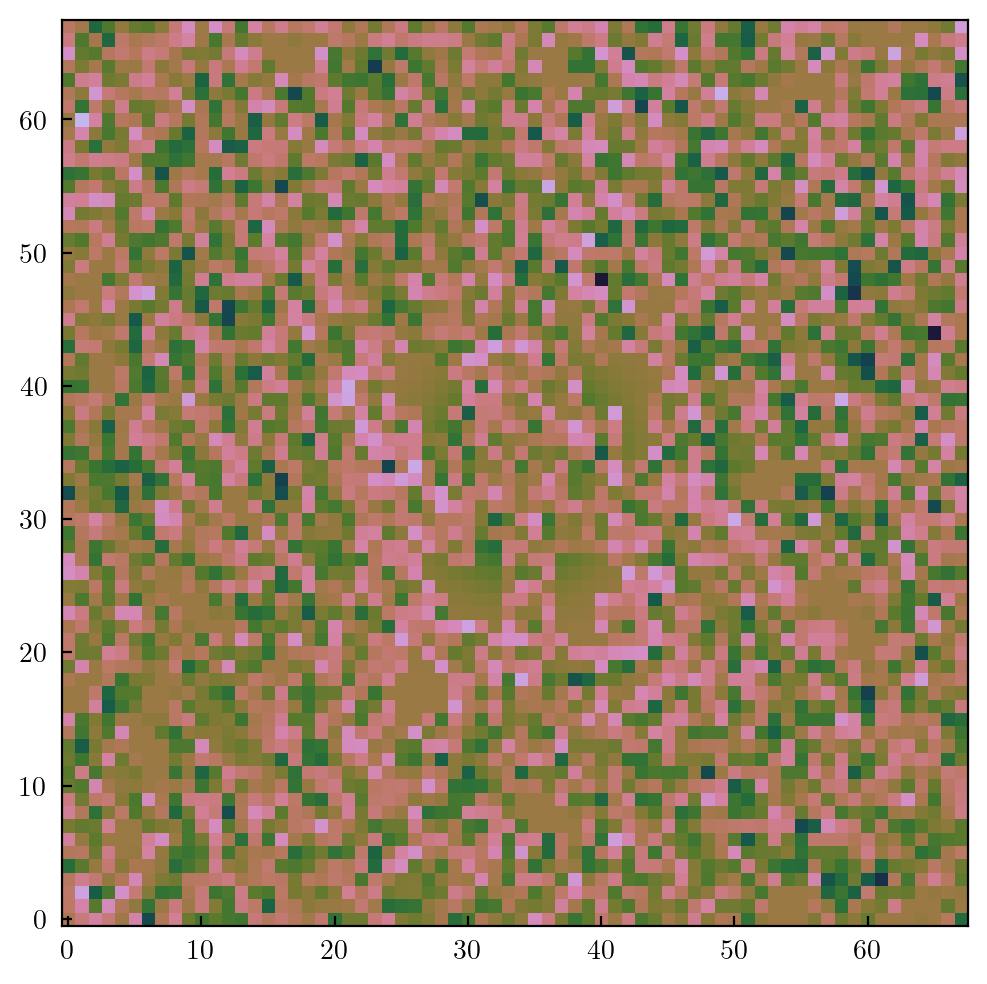

In [32]:
a, r, n, x0, y0, e, th = test_v
model = functional_models.Sersic2D(amplitude=a, r_eff=r, n=n
                                         , x_0=x0, y_0=y0
                                         , ellip=e, theta=th)

nrow, ncol = test_gal.shape
xgrid, ygrid = np.meshgrid(np.arange(ncol), np.arange(nrow))
profile = model(xgrid, ygrid)

residual = (test_gal - profile) / test_stds

fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.imshow(residual, origin='lower', cmap='cubehelix', interpolation='nearest', vmin=-5, vmax=5)

Text(0.5, 1.0, 'After')

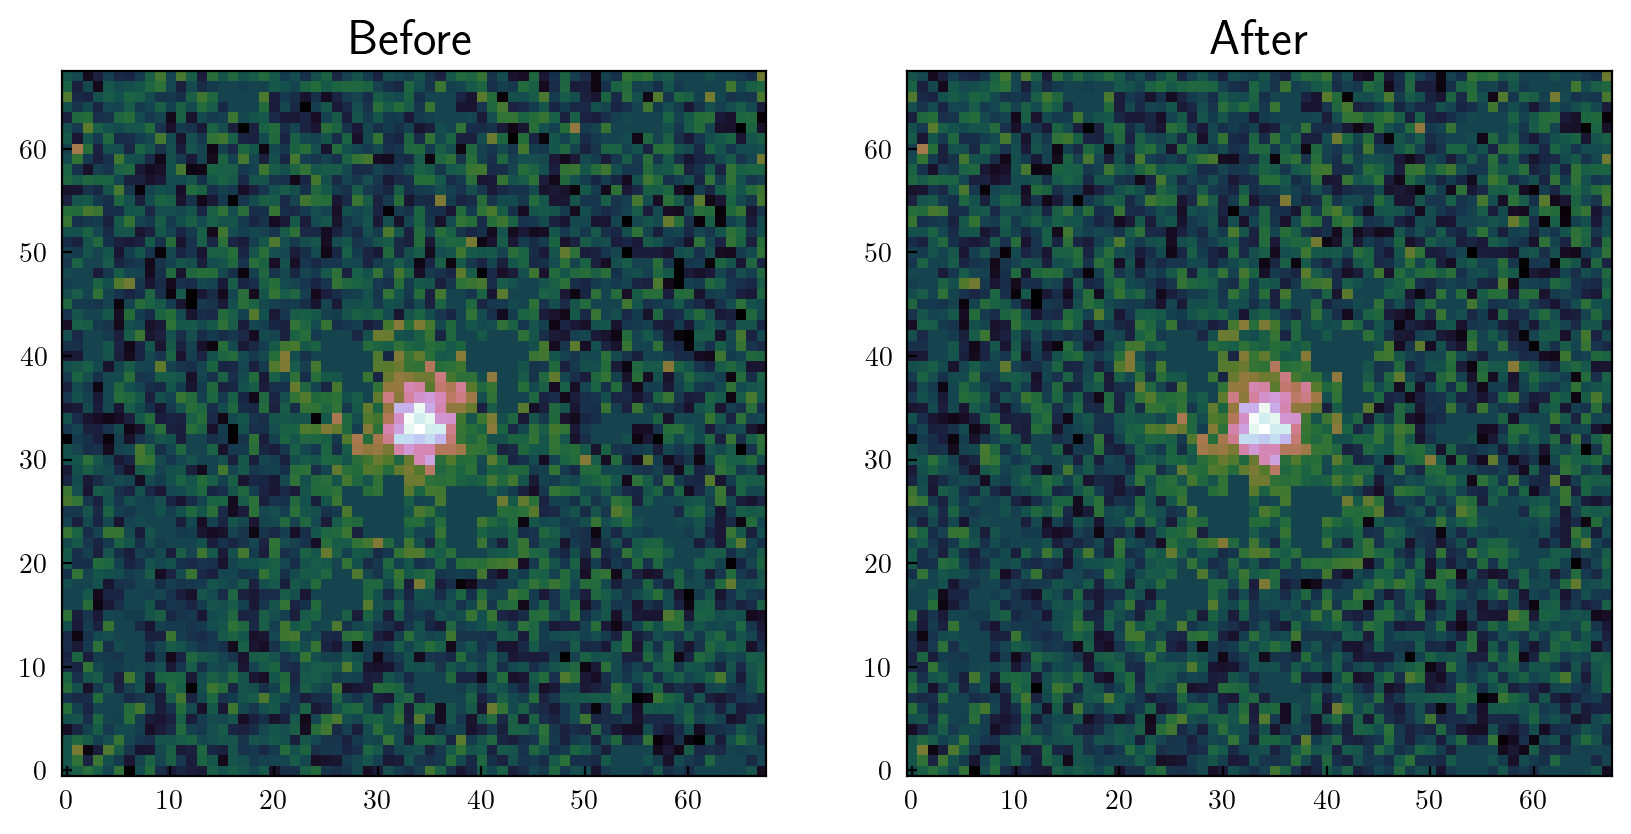

In [33]:
cl_residual = residual.copy()
cl_residual[nonzeros] = np.nan

sigma_clip = SigmaClip(sigma=3, maxiters=10)
cl_mask = sigma_clip(cl_residual)

new_test = real_test.copy()
new_test[cl_mask.mask] = 0

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6))
ax1.imshow(real_test, origin='lower', cmap='cubehelix', interpolation='nearest', vmin=-10, vmax=np.max(new_test))
ax1.set_title('Before', fontsize=18)
ax2.imshow(new_test, origin='lower', cmap='cubehelix', interpolation='nearest', vmin=-10, vmax=np.max(new_test))
ax2.set_title('After', fontsize=18)

In [743]:
### TEST ON REDMAGIC GALAXY

test_rm_img = read_fits_image('DESJ060429.5188-435511.8200_r.fits')
print(test_rm_img.shape)

(137, 137)


In [308]:
bkg = Background2D(test_rm_img, box_size=5)
bkg_img = bkg.background


'''
plt.imshow(bkg.background, origin='lower', cmap='cubehelix'#, interpolation='nearest'
           , vmin=0, vmax=50
          )
plt.xlabel('x')
plt.ylabel('y')
cbar = plt.colorbar(fraction = 0.046, pad = 0.04)
cbar.set_label(r'$r/\sigma_{\rm tot}$', labelpad=5)
#cbar.set_ticks([-1, 0, 1, 2], update_ticks=True)
plt.show()'''

sigma_clip = SigmaClip(sigma=2.0, maxiters=10)
bkgrms = StdBackgroundRMS(sigma_clip)
bkgrms_img = bkgrms(test_rm_img) 

threshold = bkg_img + (2.0 * bkgrms_img)

In [309]:
sigma = 3.0 * gaussian_fwhm_to_sigma  # FWHM = 3.
kernel = Gaussian2DKernel(sigma, x_size=3, y_size=3)
kernel.normalize()
segm = detect_sources(test_rm_img, threshold, 5, kernel)

Text(0.5, 1.0, 'Segmentation Image')

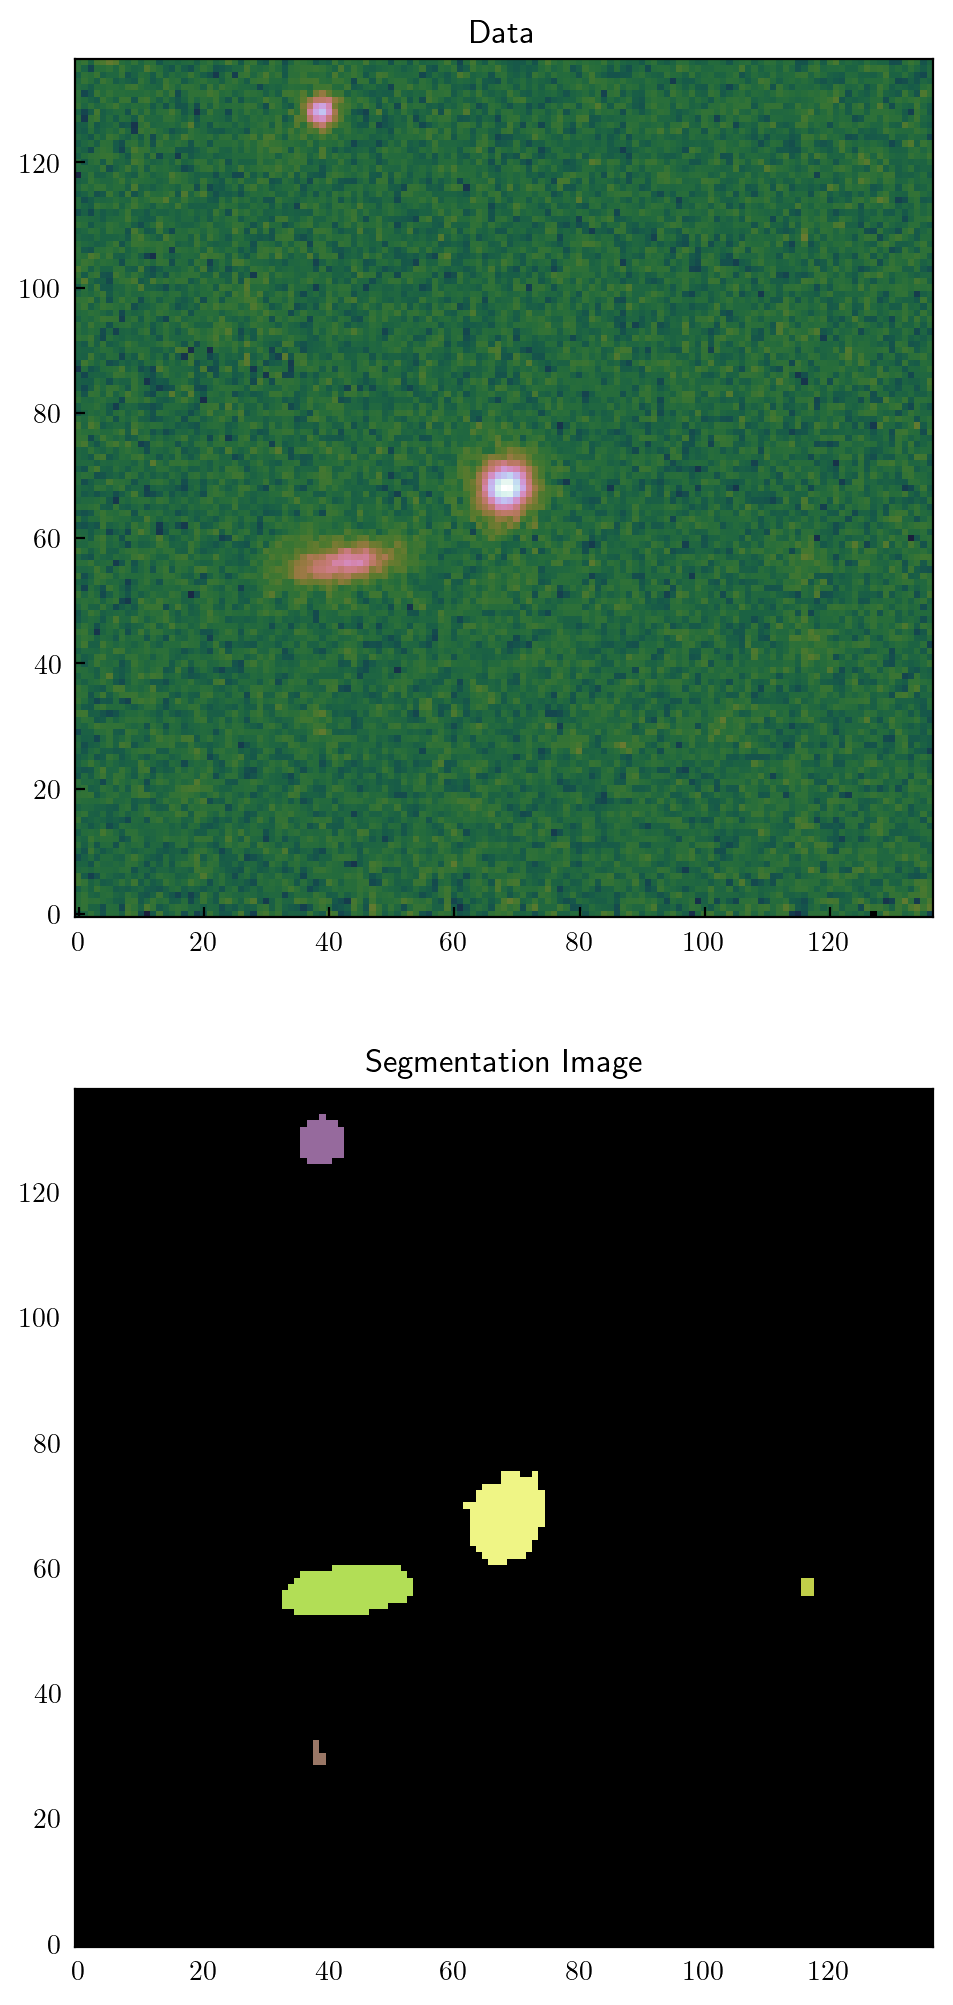

In [310]:
norm = ImageNormalize(stretch=SqrtStretch())
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12.5))
ax1.imshow(test_rm_img, origin='lower', cmap='cubehelix', norm=norm)
ax1.set_title('Data')
cmap = segm.make_cmap(seed=123)
ax2.imshow(segm, origin='lower', cmap=cmap, interpolation='nearest')
ax2.set_title('Segmentation Image')

### Testing Imported Pipeline on 16 DES redMaGiC galaxies

Very briskly written function.

In [4]:
sys.path.append('.')

from sersic_mcmc_pipeline_acloonan import SersicMCMC

In [5]:
parameters = ['DES_ID', 'amplitude', 'r_eff', 'n'
              , 'x_0', 'y_0'
              , 'ellip', 'theta']

def run_sersic_mcmc(path, ind):
    
    files = get_files(path)
    file = files[ind]

    strngs = file.split('_')
    desid = strngs[0]

    datafile = os.path.join(path, file)
    img = read_fits_image(datafile)

    test = SersicMCMC(img, desid)
    run, dist = test.mcmc_run()
    
    #test.plot_trace()
    #test.plot_gal()
    
    results = test.get_medians_calc_amplitude()
    
    trow = [desid] + list(results)
    
    return trow

In [6]:
path = '/Users/aidan/Desktop/sl_project/des-sl-selection/test_redmagic_rband/'
files = get_files(path)

chi2_table = Table(names=parameters, dtype=['str'] + ['float64'] * 7)

for i in np.arange(len(files)):
    trow = run_sersic_mcmc(path, i)
    chi2_table.add_row(vals=trow)

/Users/aidan/Desktop/sl_project/des-sl-selection/sersic_mcmc_pipeline_acloonan.py:122: RuntimeWarning: invalid value encountered in sqrt
  std_gal = np.sqrt(num * img_gal)
  0%|          | 0/800 [00:00<?, ?it/s]/Users/aidan/opt/anaconda3/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
  1%|          | 5/800 [00:00<00:17, 44.86it/s]

completed in 1.1035 sec
minimum at: [64.89974547  2.37559939  0.72852196 20.39606833 19.67460254 -0.5
 -0.33853913]
f = 0.7991147860206907


100%|██████████| 800/800 [00:19<00:00, 41.40it/s]
/Users/aidan/Desktop/sl_project/des-sl-selection/sersic_mcmc_pipeline_acloonan.py:122: RuntimeWarning: invalid value encountered in sqrt
  std_gal = np.sqrt(num * img_gal)
  0%|          | 0/800 [00:00<?, ?it/s]/Users/aidan/opt/anaconda3/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
  1%|          | 5/800 [00:00<00:17, 45.97it/s]

completed in 1.4081 sec
minimum at: [83.36727265  3.59465802  1.00300636 22.51485239 22.74447343 -0.20040968
 -0.48707596]
f = 0.642212031465877


100%|██████████| 800/800 [00:18<00:00, 42.57it/s]
/Users/aidan/Desktop/sl_project/des-sl-selection/sersic_mcmc_pipeline_acloonan.py:122: RuntimeWarning: invalid value encountered in sqrt
  std_gal = np.sqrt(num * img_gal)
  1%|          | 5/800 [00:00<00:16, 48.91it/s]

completed in 1.1988 sec
minimum at: [ 5.84576136e+01  3.40853062e+00  8.66935419e-01  1.92736330e+01
  1.93126842e+01 -1.90809849e-02  6.38068078e-02]
f = 0.6837046373197045


100%|██████████| 800/800 [00:17<00:00, 45.85it/s]
/Users/aidan/Desktop/sl_project/des-sl-selection/sersic_mcmc_pipeline_acloonan.py:122: RuntimeWarning: invalid value encountered in sqrt
  std_gal = np.sqrt(num * img_gal)
  0%|          | 0/800 [00:00<?, ?it/s]/Users/aidan/opt/anaconda3/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
  1%|          | 5/800 [00:00<00:17, 45.97it/s]

completed in 1.3009 sec
minimum at: [74.99423526  3.40142978  0.84365069 24.00328286 24.30884653 -0.10022974
 -0.5       ]
f = 0.8097144740989142


100%|██████████| 800/800 [00:19<00:00, 40.70it/s]
/Users/aidan/Desktop/sl_project/des-sl-selection/sersic_mcmc_pipeline_acloonan.py:122: RuntimeWarning: invalid value encountered in sqrt
  std_gal = np.sqrt(num * img_gal)
  0%|          | 0/800 [00:00<?, ?it/s]/Users/aidan/opt/anaconda3/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
  1%|          | 5/800 [00:00<00:20, 39.04it/s]

completed in 1.0763 sec
minimum at: [73.89568749  3.48935157  0.60808058 24.93866888 25.35950007 -0.23805294
 -0.5       ]
f = 0.7894677347929687


100%|██████████| 800/800 [00:18<00:00, 43.58it/s]
/Users/aidan/Desktop/sl_project/des-sl-selection/sersic_mcmc_pipeline_acloonan.py:122: RuntimeWarning: invalid value encountered in sqrt
  std_gal = np.sqrt(num * img_gal)
/Users/aidan/opt/anaconda3/lib/python3.7/site-packages/astropy/modeling/functional_models.py:2500: RuntimeWarning: overflow encountered in power
  return amplitude * np.exp(-bn * (z ** (1 / n) - 1))
  0%|          | 0/800 [00:00<?, ?it/s]/Users/aidan/opt/anaconda3/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
  1%|          | 5/800 [00:00<00:19, 40.81it/s]

completed in 1.3006 sec
minimum at: [ 3.78974871e+01  3.16088529e+00  8.76923566e-01  2.51177826e+01
  2.51261786e+01 -2.40909950e-02 -5.00000000e-01]
f = 0.7561410824342225


100%|██████████| 800/800 [00:18<00:00, 42.73it/s]
/Users/aidan/Desktop/sl_project/des-sl-selection/sersic_mcmc_pipeline_acloonan.py:122: RuntimeWarning: invalid value encountered in sqrt
  std_gal = np.sqrt(num * img_gal)
  0%|          | 0/800 [00:00<?, ?it/s]/Users/aidan/opt/anaconda3/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
  1%|          | 5/800 [00:00<00:16, 49.27it/s]

completed in 1.4608 sec
minimum at: [86.91767492  2.60244146  0.76379748 17.72130249 17.58715098 -0.26227227
  0.5       ]
f = 1.0905367872715248


100%|██████████| 800/800 [00:18<00:00, 43.62it/s]
/Users/aidan/Desktop/sl_project/des-sl-selection/sersic_mcmc_pipeline_acloonan.py:122: RuntimeWarning: invalid value encountered in sqrt
  std_gal = np.sqrt(num * img_gal)
  1%|          | 5/800 [00:00<00:16, 47.05it/s]

completed in 1.6402 sec
minimum at: [95.05654156  3.31436966  0.91316571 19.42766692 18.95520559  0.10595543
 -0.09966417]
f = 0.6724148292649889


 38%|███▊      | 307/800 [00:07<00:10, 46.08it/s]Traceback (most recent call last):
  File "/Users/aidan/opt/anaconda3/lib/python3.7/site-packages/emcee/ensemble.py", line 624, in __call__
    return self.f(x, *self.args, **self.kwargs)
  File "/Users/aidan/Desktop/sl_project/des-sl-selection/sersic_mcmc_pipeline_acloonan.py", line 236, in log_posterior
    loglike = self.log_likelihood(v)
  File "/Users/aidan/Desktop/sl_project/des-sl-selection/sersic_mcmc_pipeline_acloonan.py", line 220, in log_likelihood
    , ellip=self.e, theta=self.th)
  File "/Users/aidan/opt/anaconda3/lib/python3.7/site-packages/astropy/modeling/core.py", line 441, in __init__
    __init__, args, kwargs, varkwargs='kwargs')
  File "/Users/aidan/opt/anaconda3/lib/python3.7/site-packages/astropy/modeling/core.py", line 438, in __init__
    return super(cls, self).__init__(*params, **kwargs)
  File "/Users/aidan/opt/anaconda3/lib/python3.7/site-packages/astropy/modeling/core.py", line 719, in __init__
    self._in

emcee: Exception while calling your likelihood function:
  params: [ 3.25853704e+00  9.48402574e-01  1.94468671e+01  1.89464928e+01
  5.60586806e-02 -6.97482897e-03]
  args: []
  kwargs: {}
  exception:


KeyboardInterrupt: 

### Testing Imported Pipeline on 1 DES redMaGiC galaxy

Now with $I_e = 1$ during MCMC runs!

In [4]:
sys.path.append('.')

from sersic_mcmc_pipeline_acloonan import SersicMCMC

/Users/aidan/Desktop/sl_project/des-sl-selection/sersic_mcmc_pipeline_acloonan.py:122: RuntimeWarning: invalid value encountered in sqrt
  std_gal = np.sqrt(num * img_gal)
  0%|          | 0/800 [00:00<?, ?it/s]/Users/aidan/opt/anaconda3/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
  0%|          | 4/800 [00:00<00:23, 34.17it/s]

completed in 1.1408 sec
minimum at: [65.00320519  2.37430353  0.72769247 20.39601301 19.67453915 -0.5
 -0.33858276]
f = 0.7991164185952706


  2%|▏         | 14/800 [00:00<00:20, 37.48it/s]/Users/aidan/Desktop/sl_project/des-sl-selection/sersic_mcmc_pipeline_acloonan.py:225: RuntimeWarning: invalid value encountered in double_scalars
  Ie = np.sum((norm_profile * self.img_gal) / (self.stds)**2) / np.sum((norm_profile)**2 / (self.stds)**2)
100%|██████████| 800/800 [00:16<00:00, 47.22it/s]


----------------------------



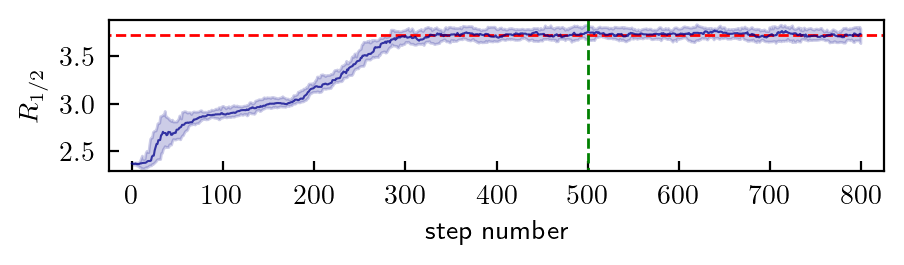

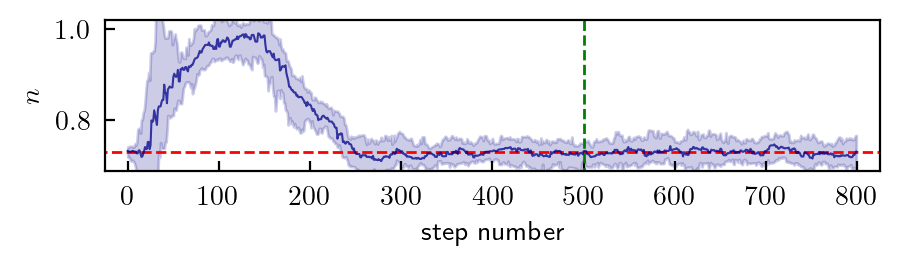

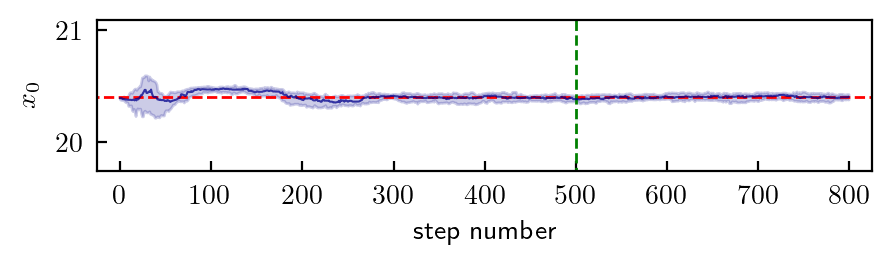

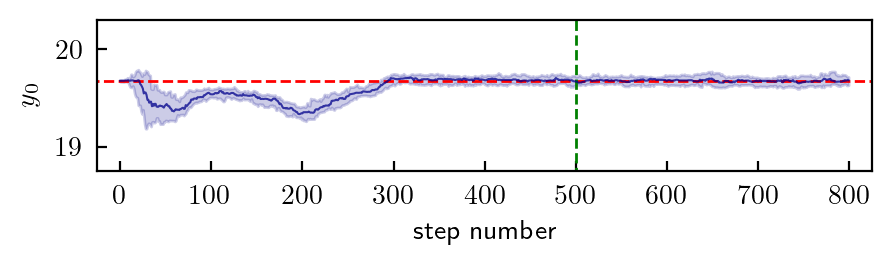

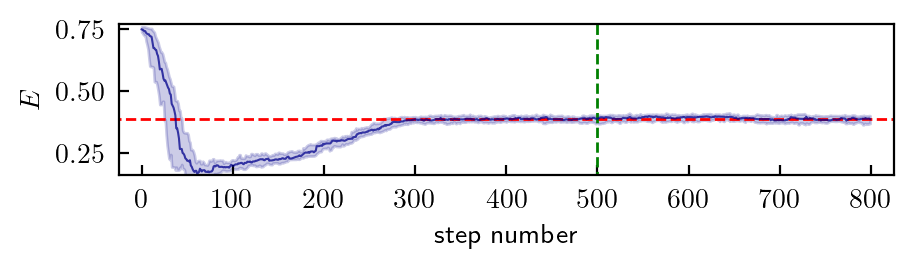

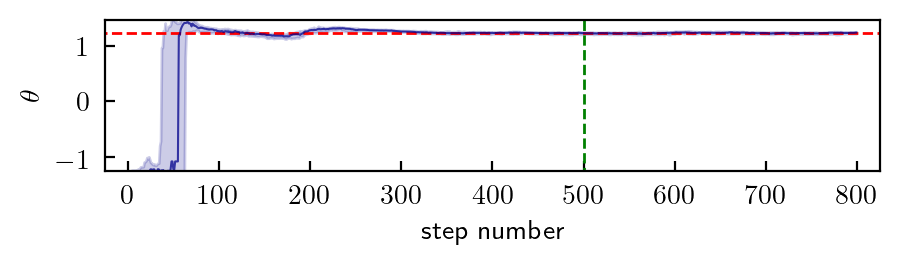

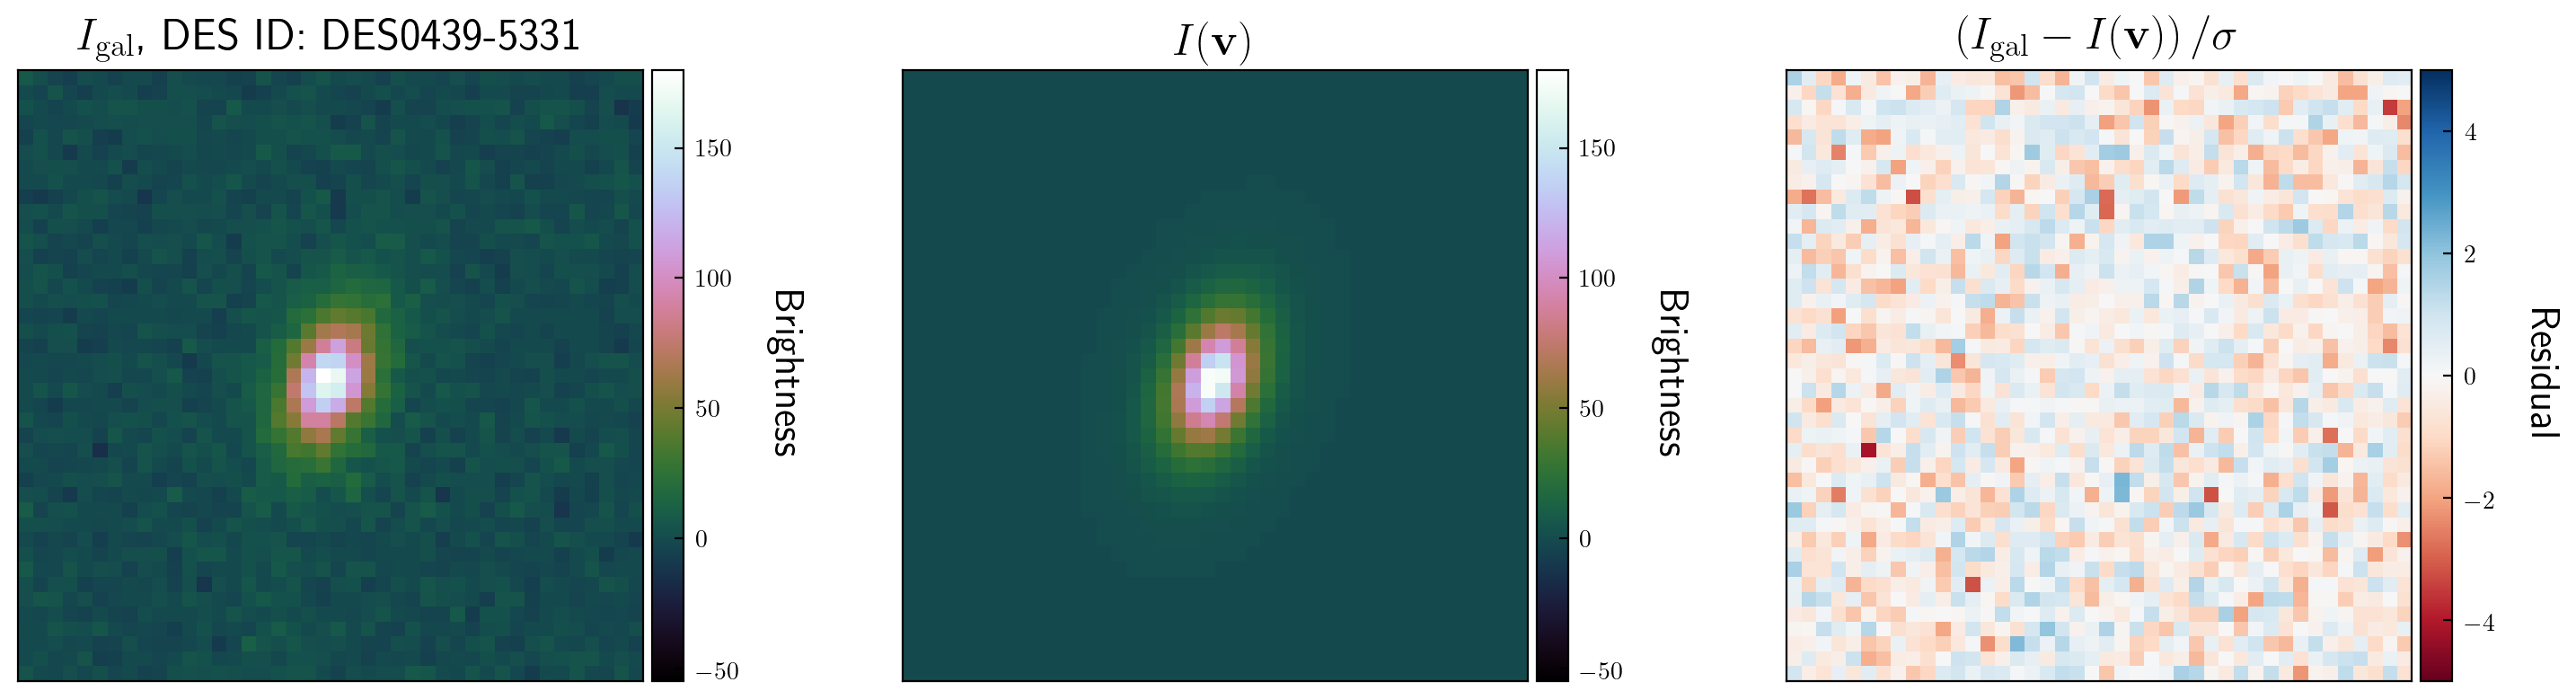

In [5]:
ind = 0

path = '/Users/aidan/Desktop/sl_project/des-sl-selection/test_redmagic_rband/'
files = get_files(path)
file = files[ind]

strngs = file.split('_')
desid = strngs[0]

datafile = os.path.join(path, file)
img = read_fits_image(datafile)

test = SersicMCMC(img, desid)
run, dist = test.mcmc_run()
test.plot_trace()
test.plot_gal()

In [21]:
results = test.get_medians_calc_amplitude()
trow = [desid] + list(results)
print(trow)

results = test.get_medians_calc_amplitude()
a = results[0]
b = results[1:7]


['DES0439-5331', 64.60996985737513, 3.7410378117054286, 0.7273245637016241, 20.39781043413427, 19.675933727089216, 0.38947684768552626, 1.232797406830022]


(7500,) (7467,)
0.3753894687634551 0.3754577741941848
0.40300979192954767 0.4029947331436544


(array([ 0.49749568,  1.32665514,  2.58697752,  6.23527916,  8.15892911,
        11.77406436, 16.84852027, 21.92297618, 25.50494506, 28.0587562 ,
        30.41356908, 27.2959295 , 20.03249261, 17.41234871, 12.93488761,
         7.82726532,  4.61012661,  2.75280941,  0.82915946,  0.63016119]),
 array([0.3488005 , 0.3528384 , 0.35687631, 0.36091421, 0.36495211,
        0.36899001, 0.37302792, 0.37706582, 0.38110372, 0.38514162,
        0.38917952, 0.39321743, 0.39725533, 0.40129323, 0.40533113,
        0.40936904, 0.41340694, 0.41744484, 0.42148274, 0.42552064,
        0.42955855]),
 <a list of 1 Patch objects>)

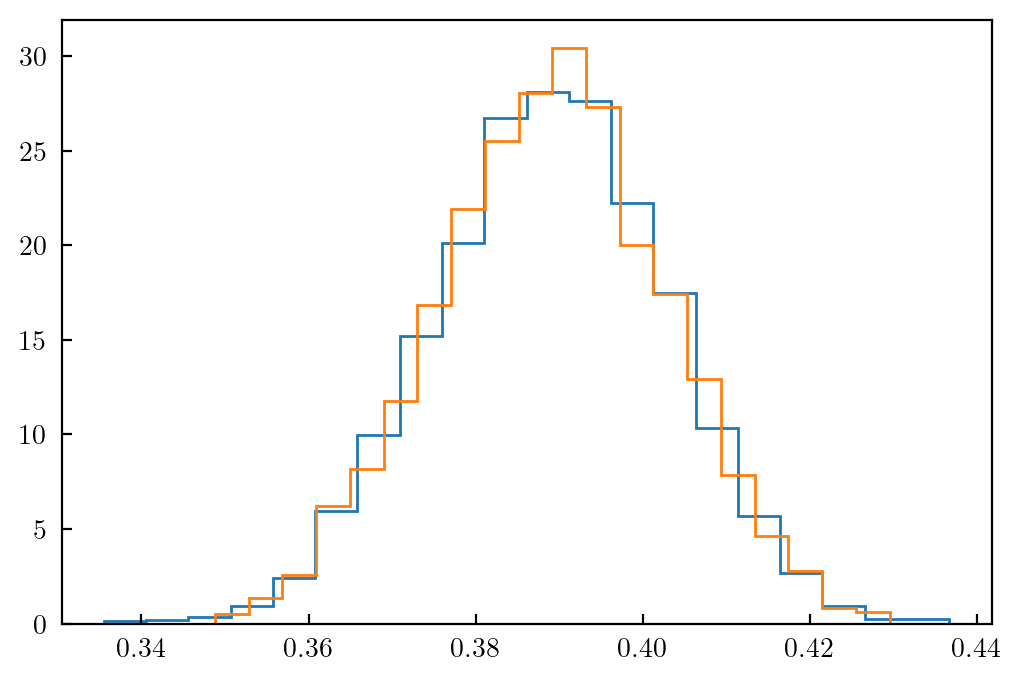

In [6]:
### IT SEEMS AS THOUGH USING np.random.normal TO CONSTRUCT INITIAL VECTOR GETS BY THIS ISSUE

# possible systematic problem in the sampling outlined here, in this graph
# this is the distribution of ellipticity for the first object in my small little catalog of 16 galaxies
# blue is not sigma-clipped, orange is sigma-clipped

# it looks as though I'll have to add a slight complication and sigma-clip the distributions before
# calculating uncertainty in each variable

# the question is: which variable is best to clip in?
# my guess is probably in ellipticity or in position angle

### I DON'T THINK THERE'S ANY MORE NEED FOR THIS

one_var = np.concatenate(dist[:,:,4])

sigma_clip = SigmaClip(sigma=3.0, maxiters=10)

one_var_sc = sigma_clip(one_var, masked=False, axis=None)

print(one_var.shape, one_var_sc.shape)
print(np.percentile(one_var, 16), np.percentile(one_var_sc, 16))
print(np.percentile(one_var, 84), np.percentile(one_var_sc, 84))

plt.hist(one_var, bins=20, density=True, histtype='step')
plt.hist(one_var_sc, bins=20, density=True, histtype='step')
#np.percentile(np.concatenate(dist[:,:,0]), 16)

#### Testing Pipeline Sampler on 1 DES redMaGiC galaxy

Likelihood function $L$ definition:

$$\ln L(\vec{y}\vert b,c) = n\ln{1\over \sqrt{2\pi}} - \sum\limits_{i=0}^{n-1}\ln\sigma_{i}-{1\over 2}\,\sum\limits_{i=0}^{n-1}\frac{(y_i-y_m)^2}{\sigma_{i}^2}=n\ln{1\over \sqrt{2\pi}} - {1\over 2} \,\sum\limits_{i=0}^{n-1}\ln\sigma_{i}^2-{1\over 2} \,\sum\limits_{i=0}^{n-1}\left(\frac{r_i}{\sigma_{i}}\right)^2,$$

$$\ln L(\vec{y}\vert b,c) \sim \,\sum\limits_{i=0}^{n-1}\ln\sigma_{i}^2-{1\over 2} \,\sum\limits_{i=0}^{n-1}\left(\frac{r_i}{\sigma_{i}}\right)^2,$$

where:

$$r_i = I_{i, \rm gal} - I_i(\mathbf{v})$$

In [45]:
from astropy.stats import SigmaClip
from photutils.background import StdBackgroundRMS
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.optimize import differential_evolution

def ellipticity2theta_q(e1, e2):
    """
    transforms complex ellipticity moduli in orientation angle and axis ratio

    :param e1: eccentricity in x-direction
    :param e2: eccentricity in xy-direction
    :return: 1 - axis ratio (minor/major), angle in radian
    """
        
    theta = np.arctan2(e2, e1)/2
        
    c = np.sqrt(e1**2+e2**2)
    c = np.minimum(c, 0.9999)
        
    q = (1-c)/(1+c)
        
    return 1 - q, theta

class SersicMCMC:

    def __init__(self, img, desid):
    
        self.img = img
        
        self.desid = desid
        
        img_gal, stds = self.get_img_uncertainties()
        self.img_gal = img_gal; self.stds = stds
        
        self.nrow, self.ncol = self.img_gal.shape
        self.xgrid, self.ygrid = np.meshgrid(np.arange(self.ncol), np.arange(self.nrow))
        
        self.params = ['R_{1/2}', 'n', 'x_0', 'y_0', 'E', '\theta']
        
        # bounds
        self.amin, self.amax = 1e-3, 300;
        self.rmin, self.rmax = 1e-3, 15;
        self.nmin, self.nmax = 1e-3, 8;
        self.x0min, self.x0max = self.ncol/2 - 3, self.ncol/2 + 3;
        self.y0min, self.y0max = self.nrow/2 - 3, self.nrow/2 + 3;
        self.e1min, self.e1max = -0.5, 0.5;
        self.e2min, self.e2max = -0.5, 0.5

    def get_img_uncertainties(self, num=1.0):
        '''
        a function that estimates uncertainties in the pixel values of redmagic 
        images, both from background and from the elliptical galaxy
    
        also returns the grid of I_gal values, which is what the Sérsic model is fit to
    
        inputs:
        --------
    
        img        ---    2D array; a DES redMaGiC image with an elliptical galaxy that a Sérsic
                          model is being fit to  
    
        outputs:
        --------
    
        img_gal    ---    2D array; alternatively img_gal_copy (explained below); the grid of I_gal values
                          calculated from estimation of a constant I_bg
    
        std_arr    ---    2D array; grid of uncertainties in corresponding pixel values from the DES image
    
        '''
    
        sigma_clip = SigmaClip(sigma=3.0, maxiters=10)
    
        bg_pixels = sigma_clip(self.img, masked=False, axis=None)
    
        ## I_bg and std_bg
    
        self.img_bg = np.mean(bg_pixels)  # I_bg
    
        bkgrms = StdBackgroundRMS(sigma_clip)
        std_bg = bkgrms(self.img) 
    
        ## I_gal
    
        img_gal = self.img - self.img_bg          # I_tot = I_gal + I_bg
    
        std_gal = np.sqrt(num * img_gal) 
    
        invalid_sgal_ind = (std_gal == np.inf) | (std_gal == -np.inf)
        std_gal[invalid_sgal_ind] = 0
    
        std_gal = np.nan_to_num(std_gal)
    
        ## estimate uncertainties

        std_arr = np.sqrt(std_gal**2 + std_bg**2)

        return img_gal, std_arr
        
    def chi2_sersic(self, v):
    
        a, r, n, x0, y0, e, th = v
        npar = len(v)
    
        # initialize Sersic profile
        model = functional_models.Sersic2D(amplitude=a, r_eff=r, n=n
                                         , x_0=x0, y_0=y0
                                         , ellip=e, theta=th)
        
        profile = model(self.xgrid, self.ygrid)
    
        pchi2 = ((self.img_gal - profile) / self.stds)**2
    
        # E^2, sum of squared errors
        e2 = np.sum(pchi2)
        norm = pchi2.size - npar
    
        # reduced chi2
        redchi2 = e2 / norm
    
        return redchi2
    
    def chi2_minimize(self, dtypes=None, npop=25):
        '''
        path       - str; path on the local system to the set of FITS image files
        parameters - list of strs; except for DES ID, each index should refer to a
                 parameter that is being fitted in the model function 
        dtypes     - list of datatypes; corresponds to the datatypes of each parameter
                 
        '''
    
        bounds = np.array([(self.amin, self.amax), (self.rmin, self.rmax)
                           , (self.nmin, self.nmax)
                            , (self.x0min, self.x0max), (self.y0min, self.y0max)
                            , (self.e1min, self.e1max), (self.e2min, self.e2max)])
        
        a0 = self.amin + (self.amax - self.amin) * np.random.uniform(0,1, size=npop)
        r0 = self.rmin + (self.rmax - self.rmin) * np.random.uniform(0,1, size=npop)
        n0 = self.nmin + (self.nmax - self.nmin) * np.random.uniform(0,1, size=npop)
        x0 = (self.ncol / 2) * np.random.uniform(0.8, 1.2, size=npop)
        y0 = (self.nrow / 2) * np.random.uniform(0.8, 1.2, size=npop)
        e10 = self.e1min + (self.e1max - self.e1max) * np.random.uniform(0,1, size=npop)
        e20 = self.e2min + (self.e2max - self.e2min) * np.random.uniform(0,1, size=npop)
        
        v0 = np.column_stack((a0, r0, n0, x0, y0, e10, e20))
        
        tstart = default_timer()
        
        run = differential_evolution(self.chi2_sersic, popsize=npop, tol = 1e-4
                                     , bounds=bounds
                                     , init = v0
                                    )
    
        print("completed in {:>.5g} sec".format(default_timer() - tstart))
        print("minimum at:",run.x)
        print('f =', run.fun)
    
        return run.x
        
    def log_priors(self, v):
        '''
        all priors are taken to be uniform distributions
        '''
    
        r, n, x0, y0, e1, e2 = v
        
        if ((self.rmin <= r <= self.rmax) 
            and (self.nmin <= n <= self.nmax) 
            and (self.x0min <= x0 <= self.x0max) and (self.y0min <= y0 <= self.y0max) 
            and (self.e1min <= e1 <= self.e1max) and (self.e2min <= e2 <= self.e2max)):
        
            lnprior = 0
            
        else:
        
            lnprior = -np.inf
            
        return lnprior
       
    def log_likelihood(self, v):
    
        self.r, self.n, self.x0, self.y0, self.e1, self.e2 = v
    
        self.e, self.th = ellipticity2theta_q(self.e1, self.e2)
    
        # initialize Sersic profile
        model = functional_models.Sersic2D(amplitude=1.0, r_eff=self.r, n=self.n
                                             , x_0=self.x0, y_0=self.y0
                                             , ellip=self.e, theta=self.th)
    
        norm_profile = model(self.xgrid, self.ygrid)
    
        # find amplitude, then multiply by I'
        Ie = np.sum((norm_profile * self.img_gal) / (self.stds)**2) / np.sum((norm_profile)**2 / (self.stds)**2)
    
        profile = Ie * norm_profile
    
        # 1/sqrt(2.*pi) factor can be omitted from the likelihood because it does not depend on model parameters
        return np.sum(-0.5 * (np.log(self.stds**2) + (self.img_gal - profile)**2 / self.stds**2))
        
    def log_posterior(self, v):
    
        # find values in prior and likelihood pdfs
        logprior = self.log_priors(v)
        loglike = self.log_likelihood(v)
    
        logpost = logprior + loglike
    
        if np.isnan(logpost):
            logpost = -np.inf
    
        return logpost
    
    def mcmc_run(self, ndim=6, nwalkers=25):
        
        min_v = self.chi2_minimize()
        
        # initial vector
        pr = np.random.rand(ndim * nwalkers).reshape((nwalkers, ndim)) + (min_v[1:] - 0.5)
        sampler = emcee.EnsembleSampler(nwalkers, ndim, self.log_posterior)

        sampler.run_mcmc(pr, 800, progress=True)
        
        samples = sampler.get_chain()

        for i in range(nwalkers):
            e, th = ellipticity2theta_q(samples[:,i][:,-2], samples[:,i][:,-1])
    
            samples[:,i][:,-2] = e
            samples[:,i][:,-1] = th
            
        self.samples = samples
        
        self.dist = self.samples[-300:]
        
        return self.samples, self.dist
    
    def plot_trace(self, cutoff = 500, figsize=(10, 3)):
        
        try:
            nsteps, ndims = np.shape(self.samples)[0], np.shape(self.samples)[2]
        except:
            nsteps, ndims = np.shape(self.samples)[0], 1
        
        medians = np.median(self.samples, axis=1)
    
        sig_lb = np.percentile(self.samples, 16, axis=1)
        sig_ub = np.percentile(self.samples, 84, axis=1)
        
        for d in range(ndims):
        
            fig = plt.figure(figsize=figsize)
            ax = fig.add_subplot(111)
    
            ax.set_ylabel(r'${}$'.format(self.params[d])) # label axis 
            ax.set_xlabel(r'step number')
            
            if ndims == 1:
            
                avr = np.mean(medians[-100:])
            
                xl = np.linspace(-50, len(medians)+50, 50)  # average
                yl = 0 * xl + avr
            
                xc = 0 * xl + cutoff
    
                ax.plot(xl, yl, '--', c='r', lw=1.0)
                ax.plot(xc, xl, '--', c='g', lw=1.0)

                ax.set_xlim(-25, len(medians) + 25)
                ax.set_ylim(np.min(medians) * 0.85, np.max(medians) * 1.15)
            
        
                ax.plot(np.arange(0,nsteps,1), medians, alpha=0.75, lw=0.5, c='darkslateblue', label='d={:d}'.format(d))
                ax.fill_between(np.arange(0,nsteps,1), sig_lb, sig_ub, alpha=0.2)
        
            else:
            
                avr = np.mean(medians[:,d][-100:])
                
                xl = np.linspace(-50, len(medians[:,d])+50, 50)
                yl = 0 * xl + avr
            
                xc = 0 * xl + cutoff
    
                ax.plot(xl, yl, '--', c='r', lw=1.0)
                ax.plot(xc, xl, '--', c='g', lw=1.0)

                ax.set_xlim(-25, len(medians[:,d]) + 25)
                ax.set_ylim(np.min(medians[:,d]) * 0.97, np.max(medians[:,d]) * 1.03)
            
                ax.plot(np.arange(0,nsteps), medians[:,d], alpha=0.75, lw=0.75, c='darkblue', label='d={:d}'.format(d))
                ax.fill_between(np.arange(0,nsteps), sig_lb[:,d], sig_ub[:,d], color='darkblue', alpha=0.2)
    
    def plot_raw_profile_rr(self):
    
        diff_img = (self.img_gal - self.profile) / self.stds
    
        fig, ax = plt.subplots(1,3)
        fig.set_figheight(4.5)
        fig.set_figwidth(18)

        imgs = np.array([self.img_gal, self.profile, diff_img])
    
        imgs_min = np.min(imgs, axis=(1,2))
        imgs_max = np.max(imgs, axis=(1,2))
    
        # lower bound not 0 if negative pixel values in des images not removed
        cbar_lb = np.min(imgs_min[:2]) - 40
        cbar_ub = np.max(imgs_max[:2])

        ax[0].set_title(r'$I_{\rm gal}$, DES ID: ' + self.desid
                        , fontsize=18)
        ax[1].set_title(r'$I(\mathbf{v})$', fontsize=18)
        ax[2].set_title(r'$\left( I_{\rm gal} - I(\mathbf{v}) \right) / \sigma$', fontsize=18)

        ax[0].set_ylabel(r'$y$', fontsize=18)
    
        for i, image in enumerate(imgs):
    
            if i == 2:
                im = ax[i].imshow(image, origin='lower', cmap='RdBu', interpolation='nearest'
                              , vmin=-5, vmax=5
                             )
            
                divider = make_axes_locatable(ax[i])
                cax = divider.append_axes('right', size='5%', pad=0.05)
                cbar = fig.colorbar(im, cax=cax)
                cbar.set_label('Residual', rotation=270, labelpad=25, fontsize=16)
        
            else:
                im = ax[i].imshow(image, origin='lower', cmap='cubehelix', interpolation='nearest'  # cmap = cubehelix, viridis
                              , vmin=cbar_lb, vmax=cbar_ub
                             )
            
                divider = make_axes_locatable(ax[i])
                cax = divider.append_axes('right', size='5%', pad=0.05)
                cbar = fig.colorbar(im, cax=cax)
                cbar.set_label('Brightness', rotation=270, labelpad=25, fontsize=16)
            
            ax[i].tick_params(axis='both', which='major', labelsize=16)
            ax[i].tick_params(axis='both', which='minor', labelsize=16)
            ax[i].set_xlabel(r'$x$', fontsize=18)
            
    def get_medians_calc_amplitude(self):
    
        self.medians = np.array([])

        for i in range(self.dist.shape[2]):
    
            gs1d = self.dist[:,:,i]
    
            gs1d_con = np.concatenate(gs1d)

            mid = np.median(gs1d_con)
    
            self.medians = np.append(self.medians, mid)

        ri, ni, x0i, y0i, ei, thi = self.medians.copy()
        
        sersic = functional_models.Sersic2D(amplitude=1.0, r_eff=ri, n=ni
                                            , x_0=x0i, y_0=y0i
                                            , ellip=ei, theta=thi)

        self.norm_profile = sersic(self.xgrid, self.ygrid)
    
        # find amplitude
        self.Ie = np.sum((self.norm_profile * self.img_gal) / (self.stds)**2) / np.sum((self.norm_profile)**2 / (self.stds)**2)
    
        return self.medians, self.Ie
        
    def plot_gal(self):
        
        print('----------------------------\n')

        self.medians, self.Ie = self.get_medians_calc_amplitude()

        self.r_med, self.n_med, self.x0_med, self.y0_med, self.e_med, self.th_med = self.medians.copy()
        sersic = functional_models.Sersic2D(amplitude=self.Ie, r_eff=self.r_med, n=self.n_med
                                                , x_0=self.x0_med, y_0=self.y0_med
                                                , ellip=self.e_med, theta=self.th_med)

        self.profile = sersic(self.xgrid, self.ygrid)
        
        self.plot_raw_profile_rr()

/Users/aidan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:87: RuntimeWarning: invalid value encountered in sqrt
  0%|          | 0/800 [00:00<?, ?it/s]/Users/aidan/opt/anaconda3/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
/Users/aidan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:194: RuntimeWarning: invalid value encountered in double_scalars
/Users/aidan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:194: RuntimeWarning: divide by zero encountered in double_scalars
/Users/aidan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:196: RuntimeWarning: invalid value encountered in multiply
  1%|          | 5/800 [00:00<00:16, 49.57it/s]

completed in 1.0653 sec
minimum at: [64.80451749  2.37679434  0.72927983 20.39610214 19.67466089 -0.5
 -0.3385167 ]
f = 0.7991161899770376


/Users/aidan/opt/anaconda3/lib/python3.7/site-packages/astropy/modeling/functional_models.py:2500: RuntimeWarning: overflow encountered in power
  return amplitude * np.exp(-bn * (z ** (1 / n) - 1))
100%|██████████| 800/800 [00:16<00:00, 48.77it/s]


----------------------------



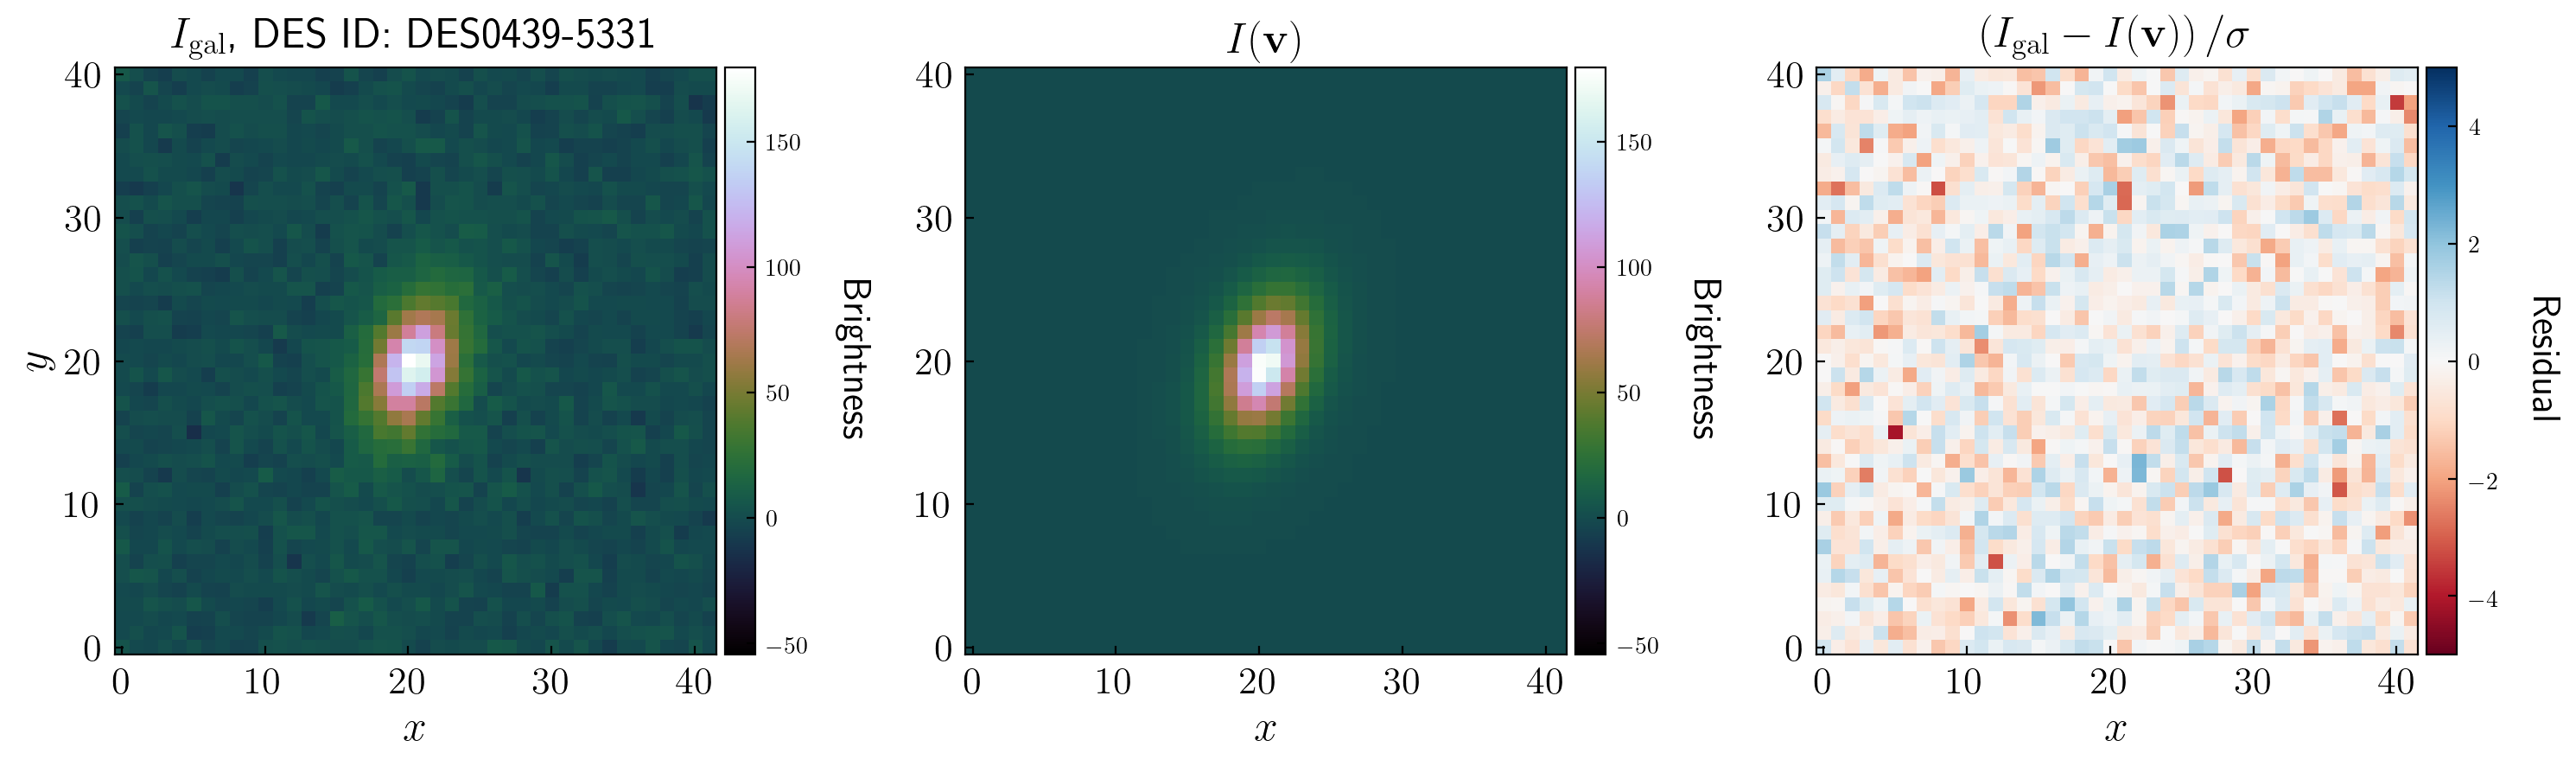

In [46]:
ind = 0

path = '/Users/aidan/Desktop/sl_project/des-sl-selection/test_redmagic_rband/'
files = get_files(path)
file = files[ind]

strngs = file.split('_')
desid = strngs[0]

datafile = os.path.join(path, file)
img = read_fits_image(datafile)

test = SersicMCMC(img, desid)
run, dist = test.mcmc_run()
test.plot_gal()

### Testing Individual Functions within Pipeline

Branch mcmc_amp_opt: testing with $I_e = 1$

In [8]:
def chi2_sersic(v, *args):
    
    a, r, n, x0, y0, e, th = v
    npar = len(v)
    
    # args is the grid of I_gal values and grid of uncertainties
    #print(args[0][0])
    img_gal = args[0]; stds = args[1]
    nrow, ncol = img_gal.shape
    xgrid, ygrid = np.meshgrid(np.arange(ncol), np.arange(nrow))
    
    # initialize Sersic profile
    model = functional_models.Sersic2D(amplitude=a, r_eff=r, n=n
                                         , x_0=x0, y_0=y0
                                         , ellip=e, theta=th)
    profile = model(xgrid, ygrid)
    
    pchi2 = ((img_gal - profile) / stds)**2
    
    # E^2, sum of squared errors
    e2 = np.sum(pchi2)
    norm = pchi2.size - npar
    
    # reduced chi2
    redchi2 = e2 / norm
    
    #test_stat = np.abs(redchi2 - 1)
    
    #if np.isnan(e2):
     #   print(model.parameters)
    
    return redchi2

In [9]:
### CALCULATION OF THE POSTERIOR FUNCTION

def ellipticity2theta_q(e1, e2):
    """
    transforms complex ellipticity moduli in orientation angle and axis ratio

    :param e1: eccentricity in x-direction
    :param e2: eccentricity in xy-direction
    :return: 1 - axis ratio (minor/major), angle in radian
    """
    theta = np.arctan2(e2, e1)/2
    c = np.sqrt(e1**2+e2**2)
    c = np.minimum(c, 0.9999)
    q = (1-c)/(1+c)
    return 1 - q, theta

def log_likelihood(v, *args):
    '''
    uses the above definition of likelihood
    '''
    
    #a, r, n, x0, y0, e1, e2 = v
    r, n, x0, y0, e1, e2 = v
    
    e, th = ellipticity2theta_q(e1, e2)
    
    # args is the grid of I_gal values and grid of uncertainties
    img_gal = args[0]; stds = args[1]
    
    nrow, ncol = img_gal.shape
    xgrid, ygrid = np.meshgrid(np.arange(ncol), np.arange(nrow))
    
    # initialize Sersic profile
    model = functional_models.Sersic2D(amplitude=1.0, r_eff=r, n=n
                                         , x_0=x0, y_0=y0
                                         , ellip=e, theta=th) 
    
    norm_profile = model(xgrid, ygrid)
    
    # find amplitude, then multiply by I'
    I0 = np.sum((norm_profile * img_gal) / (stds)**2) / np.sum((norm_profile)**2 / (stds)**2)
    
    profile = I0 * norm_profile
    
    # 1/sqrt(2.*pi) factor can be omitted from the likelihood because it does not depend on model parameters
    return np.sum(-0.5 * (np.log(stds**2) + (img_gal - profile)**2 / stds**2))
    
    #return -chi2 / 2

def log_priors(v):
    '''
    all priors are taken to be uniform distributions
    '''
    
    #a, r, n, x0, y0, e1, e2 = v
    r, n, x0, y0, e1, e2 = v
    
    # bounds
    #amin, amax = 1e-3, 300;
    rmin, rmax = 1e-3, 15;
    nmin, nmax = 1e-3, 8;
    x0min, x0max = ncol/2 - 3, ncol/2 + 3;
    y0min, y0max = nrow/2 - 3, nrow/2 + 3;
    e1min, e1max = -0.5, 0.5;
    e2min, e2max = -0.5, 0.5
    
    if (#(amin <= a <= amax) and 
        (rmin <= r <= rmax) and (nmin <= n <= nmax) 
        and (x0min <= x0 <= x0max) and (y0min <= y0 <= y0max) 
        and (e1min <= e1 <= e1max) and (e2min <= e2 <= e2max)):
        
        lnprior = 0
            
    else:
        
        lnprior = -np.inf
            
    return lnprior

def log_posterior(v, *args):
    
    # find values in prior and likelihood pdfs
    logprior = log_priors(v)
    loglike = log_likelihood(v, *args)
    
    logpost = logprior + loglike
    
    if np.isnan(logpost):
        logpost = -np.inf
        #print(v)
    
    return logpost

In [10]:
def rms(arr):
    '''
    calculates the root mean square of an array
    '''
    sq_mean = np.mean(arr**2)
    return np.sqrt(sq_mean)

def get_img_uncertainties(img, num=1.0):
    '''
    a function that estimates uncertainties in the pixel values of redmagic 
    images, both from background and from the elliptical galaxy
    
    also returns the grid of I_gal values, which is what the Sérsic model is fit to
    
    inputs:
    --------
    
    img        ---    2D array; a DES redMaGiC image with an elliptical galaxy that a Sérsic
                      model is being fit to  
    
    outputs:
    --------
    
    img_gal    ---    2D array; alternatively img_gal_copy (explained below); the grid of I_gal values
                      calculated from estimation of a constant I_bg
    
    std_arr    ---    2D array; grid of uncertainties in corresponding pixel values from the DES image
                      
    
    PSEUDOCODE:
    
    get background and galaxy pixels as before
    
    I_bg = np.mean(bg_pixels)
    
    sigma_bg = root mean square of bg_pixels
    
    I_gal = I_tot - I_bg
    
    sigma_gal = np.sqrt(I_gal)
    
    invalid_sgal_ind = where sigma_gal is inf or nan
    
    sigma_gal[invalid_sgal_ind] = 0
    
    sigma_tot = np.sqrt(sigma_bg**2 + sigma_gal**2)
    
    return I_gal, sigma_tot
    
    '''
    
    sigma_clip = SigmaClip(sigma=3.0, maxiters=10)
    
    bg_pixels = sigma_clip(img, masked=False, axis=None)
    
    ## I_bg and std_bg
    
    img_bg = np.mean(bg_pixels)  # I_bg
    
    #std_bg = rms(img_bg)
    
    bkgrms = StdBackgroundRMS(sigma_clip)
    std_bg = bkgrms(img) 
    
    ## I_gal
    
    img_gal = img - img_bg          # I_tot = I_gal + I_bg
    
    std_gal = np.sqrt(num * img_gal) 
    
    invalid_sgal_ind = (std_gal == np.inf) | (std_gal == -np.inf)
    std_gal[invalid_sgal_ind] = 0
    
    std_gal = np.nan_to_num(std_gal)
    
    ## estimate uncertainties

    std_arr = np.sqrt(std_gal**2 + std_bg**2)

    return img_gal, std_arr

In [11]:
from scipy.optimize import differential_evolution

# run on one file, w/ a function

'''
def chi2_sersic(v, *args):
    
    loglike = log_likelihood(v, *args)
    
    return -2 * loglike
'''
    
def chi2_sersic(v, *args):
    
    a, r, n, x0, y0, e, th = v
    npar = len(v)
    
    # args is the grid of I_gal values and grid of uncertainties
    #print(args[0][0])
    img_gal = args[0]; stds = args[1]
    nrow, ncol = img_gal.shape
    xgrid, ygrid = np.meshgrid(np.arange(ncol), np.arange(nrow))
    
    # initialize Sersic profile
    model = functional_models.Sersic2D(amplitude=a, r_eff=r, n=n
                                         , x_0=x0, y_0=y0
                                         , ellip=e, theta=th)
    profile = model(xgrid, ygrid)
    
    pchi2 = ((img_gal - profile) / stds)**2
    
    # E^2, sum of squared errors
    e2 = np.sum(pchi2)
    norm = pchi2.size - npar
    
    # reduced chi2
    redchi2 = e2 / norm
    
    #test_stat = np.abs(redchi2 - 1)
    
    #if np.isnan(e2):
     #   print(model.parameters)
    
    return redchi2

def chi2_minimize(img_gal, stds, dtypes=None, npop=25):
    '''
    path       - str; path on the local system to the set of FITS image files
    parameters - list of strs; except for DES ID, each index should refer to a
                 parameter that is being fitted in the model function 
    dtypes     - list of datatypes; corresponds to the datatypes of each parameter
                 
    '''
        
    # define args, bounds
    args = [img_gal, stds]
        
    nrow, ncol = img_gal.shape

    # bounds
    amin, amax = 1e-3, 300;
    rmin, rmax = 1e-3, 15;
    nmin, nmax = 1e-3, 8;
    x0min, x0max = ncol/2 - 3, ncol/2 + 3;
    y0min, y0max = nrow/2 - 3, nrow/2 + 3;
    e1min, e1max = -0.5, 0.5;
    e2min, e2max = -0.5, 0.5
    
    bounds = np.array([(amin, amax), (rmin, rmax), (nmin, nmax)
                        , (x0min, x0max), (y0min, y0max)
                        , (e1min, e1max), (e2min, e2max)])
        
    a0 = amin + (amax - amin) * np.random.uniform(0,1, size=npop)
    r0 = rmin + (rmax - rmin) * np.random.uniform(0,1, size=npop)
    n0 = nmin + (nmax - nmin) * np.random.uniform(0,1, size=npop)
    x0 = (ncol / 2) * np.random.uniform(0.8, 1.2, size=npop)
    y0 = (nrow / 2) * np.random.uniform(0.8, 1.2, size=npop)
    e10 = e1min + (e1max - e1max) * np.random.uniform(0,1, size=npop)
    e20 = e2min + (e2max - e2min) * np.random.uniform(0,1, size=npop)
        
    v0 = np.column_stack((a0, r0, n0, x0, y0, e10, e20))
        
    tstart = default_timer()
        
    run = differential_evolution(chi2_sersic, popsize=npop, tol = 1e-4
                                 , bounds=bounds, args=args
                                 , init = v0
                                )
    
    print("completed in {:>.5g} sec".format(default_timer() - tstart))
    print("minimum at:",run.x)
    print('f =', run.fun)
    
    return run.x

In [12]:
# get a des redmagic image

ind = 0

path = '/Users/aidan/Desktop/sl_project/des-sl-selection/test_redmagic_rband/'
files = get_files(path)
file = files[ind]

datafile = os.path.join(path, file)
img = read_fits_image(datafile)

img_gal, stds = get_img_uncertainties(img)

args = [img_gal, stds]

nrow, ncol = img_gal.shape

/Users/aidan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:69: RuntimeWarning: invalid value encountered in sqrt


In [13]:
min_v = chi2_minimize(img_gal, stds)

completed in 1.123 sec
minimum at: [64.90054622  2.37558725  0.72851698 20.39606322 19.67459561 -0.5
 -0.33855008]
f = 0.799114785970391


In [14]:
# initial vector
ndim = 6
nwalkers = 25
pr = np.random.rand(ndim * nwalkers).reshape((nwalkers, ndim)) + (min_v[1:] - 0.5)
#pr = np.random.rand(ndim * nwalkers).reshape((nwalkers, ndim)) + (min_v - 0.5)
#pr = np.random.rand(ndim * nwalkers).reshape((nwalkers, ndim)) + np.array([70., 3.5, 0.5, ncol/2 - 0.5, nrow/2 - 0.5, -0.5, -0.5])
print(pr.shape)

(25, 6)


In [22]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=args)

sampler.run_mcmc(pr, 800, progress=True)

/Users/aidan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in double_scalars
  0%|          | 0/800 [00:00<?, ?it/s]/Users/aidan/opt/anaconda3/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
/Users/aidan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:41: RuntimeWarning: divide by zero encountered in double_scalars
/Users/aidan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in multiply
/Users/aidan/opt/anaconda3/lib/python3.7/site-packages/astropy/modeling/functional_models.py:2500: RuntimeWarning: overflow encountered in power
  return amplitude * np.exp(-bn * (z ** (1 / n) - 1))
100%|██████████| 800/800 [00:17<00:00, 45.92it/s]


State([[ 3.71751634  0.77315311 20.40771297 19.65954403 -0.19135849  0.16961152]
 [ 3.69148228  0.72513553 20.44029374 19.74069316 -0.18992424  0.12988669]
 [ 3.63305003  0.68069454 20.41307068 19.74284163 -0.18782761  0.14338553]
 [ 2.08403765  0.55603185 20.13614308 19.57287044 -0.93200718 -0.05473271]
 [ 3.65605444  0.71590596 20.46134586 19.62488516 -0.16620029  0.1513453 ]
 [ 3.74837044  0.75382263 20.41852075 19.75340672 -0.20405042  0.14588225]
 [ 3.63983557  0.75768037 20.34891025 19.64766046 -0.18451416  0.14468287]
 [ 3.80001051  0.73294832 20.40341813 19.66231192 -0.19299207  0.15240763]
 [ 1.97629824  0.83752404 20.61697776 20.07619765 -0.96758164  0.10540411]
 [ 3.77693273  0.7695321  20.47248998 19.63855538 -0.19393966  0.15820832]
 [ 3.64792681  0.72245817 20.34668969 19.71645147 -0.18109515  0.14201123]
 [ 3.59455705  0.7129673  20.34006926 19.6412846  -0.17235593  0.12113242]
 [ 3.68831681  0.76535042 20.38299417 19.74776239 -0.18300802  0.15501038]
 [ 3.71415899  0.71

In [23]:
samples = sampler.get_chain()
print(samples.shape)

for i in range(nwalkers):
    e, th = ellipticity2theta_q(samples[:,i][:,-2], samples[:,i][:,-1])
    
    samples[:,i][:,-2] = e
    samples[:,i][:,-1] = th

#ellipticity2theta_q(0.01, 0.02)

(800, 25, 6)


In [24]:
def plot_trace(x, params, cutoff = 500, figsize=(10, 3)):
    try:
        nsteps, ndims = np.shape(x)[0], np.shape(x)[2]
    except:
        nsteps, ndims = np.shape(x)[0], 1
        
    medians = np.median(x, axis=1)
    
    sig_lb = np.percentile(x, 16, axis=1)
    sig_ub = np.percentile(x, 84, axis=1)
        
    #plt.figure(figsize=figsize)
    for d in range(ndims):
        
        fig = plt.figure(figsize=figsize)
        ax = fig.add_subplot(111)
    
        ax.set_ylabel(r'${}$'.format(params[d])) # label axis 
        ax.set_xlabel(r'step number')
        
        if ndims == 1:
            
            avr = np.mean(medians[-100:])
            
            xl = np.linspace(-50, len(medians)+50, 50)  # average
            yl = 0 * xl + avr
            
            xc = 0 * xl + cutoff
    
            ax.plot(xl, yl, '--', c='r', lw=1.0)
            ax.plot(xc, xl, '--', c='g', lw=1.0)

            ax.set_xlim(-25, len(medians) + 25)
            ax.set_ylim(np.min(medians) * 0.85, np.max(medians) * 1.15)
            
        
            ax.plot(np.arange(0,nsteps,1), medians, alpha=0.75, lw=0.5, c='darkslateblue', label='d={:d}'.format(d))
            ax.fill_between(np.arange(0,nsteps,1), sig_lb, sig_ub, alpha=0.2)
        
        else:
            
            avr = np.mean(medians[:,d][-100:])
            
            xl = np.linspace(-50, len(medians[:,d])+50, 50)
            yl = 0 * xl + avr
            
            xc = 0 * xl + cutoff
    
            ax.plot(xl, yl, '--', c='r', lw=1.0)
            ax.plot(xc, xl, '--', c='g', lw=1.0)

            ax.set_xlim(-25, len(medians[:,d]) + 25)
            ax.set_ylim(np.min(medians[:,d]) * 0.97, np.max(medians[:,d]) * 1.03)
            
            ax.plot(np.arange(0,nsteps), medians[:,d], alpha=0.75, lw=0.75, c='darkblue', label='d={:d}'.format(d))
            ax.fill_between(np.arange(0,nsteps), sig_lb[:,d], sig_ub[:,d], color='darkblue', alpha=0.2)

In [25]:
def calc_amplitude(samples):
    
    good_samples = samples[-300:]
    
    medians = np.array([])

    for i in range(good_samples.shape[2]):
    
        gs1d = good_samples[:,:,i]
    
        gs1d_con = np.concatenate(gs1d)

        mid = np.median(gs1d_con)
    
        medians = np.append(medians, mid)

    nrow, ncol = img_gal.shape
    x, y = np.meshgrid(np.arange(ncol), np.arange(nrow))

    ri, ni, x0i, y0i, ei, thi = medians.copy()
    print(medians)
    sersic = functional_models.Sersic2D(amplitude=1.0, r_eff=ri, n=ni
                                            , x_0=x0i, y_0=y0i
                                            , ellip=ei, theta=thi)

    norm_profile = sersic(x, y)
    print(np.max(norm_profile))
    
    # find amplitude
    I0 = np.sum((norm_profile * img_gal) / (stds)**2) / np.sum((norm_profile)**2 / (stds)**2)
    
    profile = norm_profile * I0
    
    return I0, profile

test, profile = calc_amplitude(samples)
print(test)

[ 3.72548823  0.73366302 20.397784   19.66496722  0.39271995  1.22849593]
2.7440058863276526
65.11993923377841


In [26]:
samples[:,:,0].shape

(800, 25)

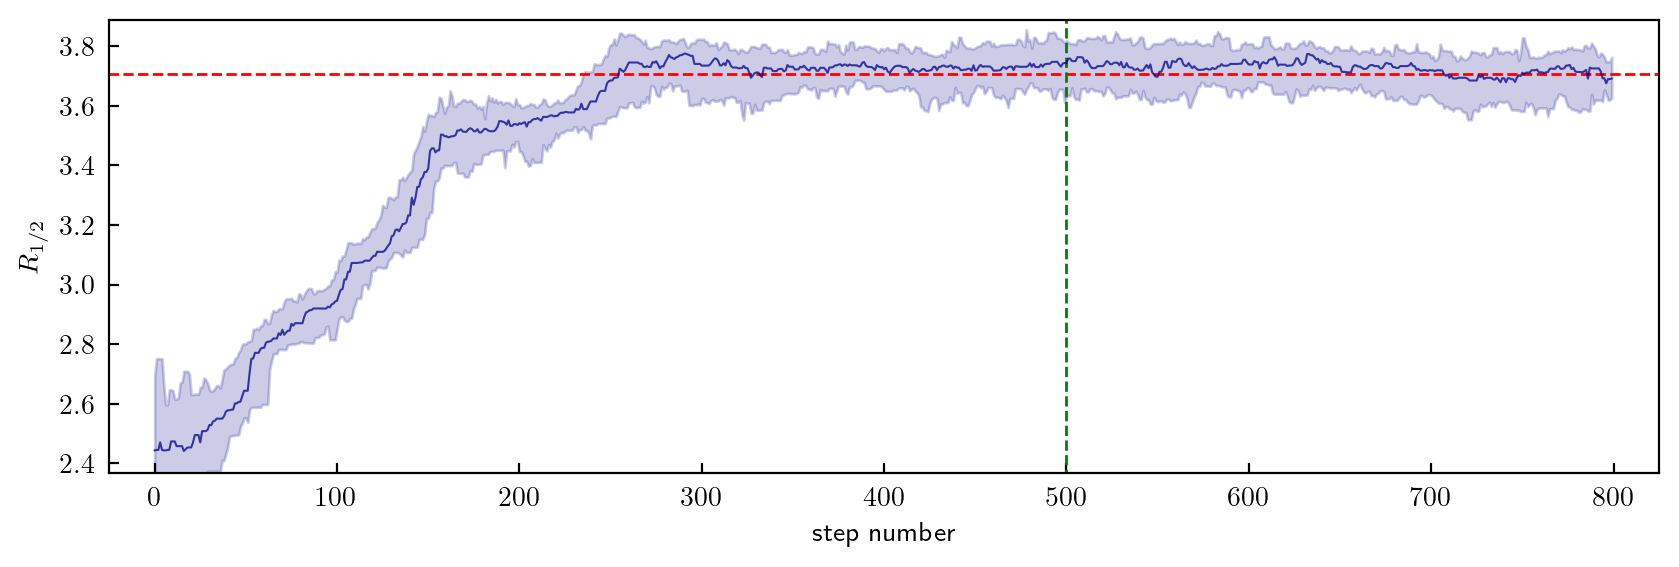

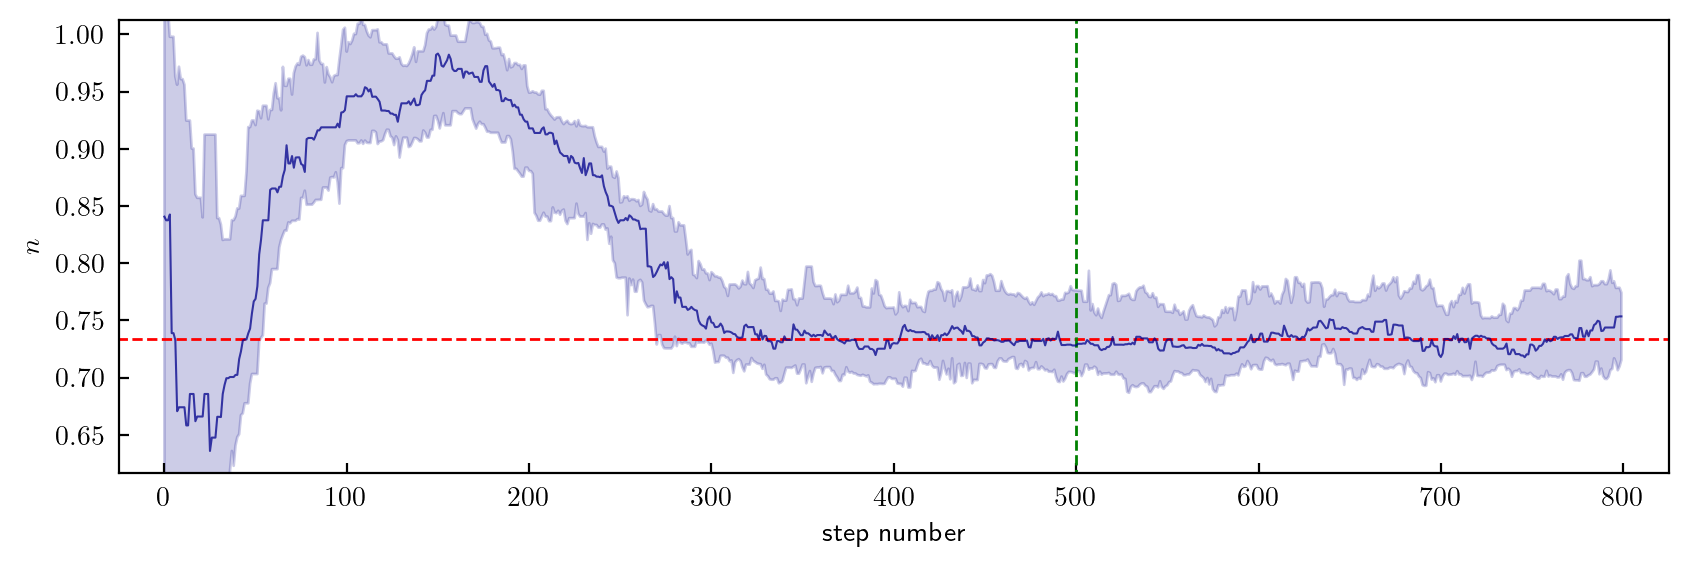

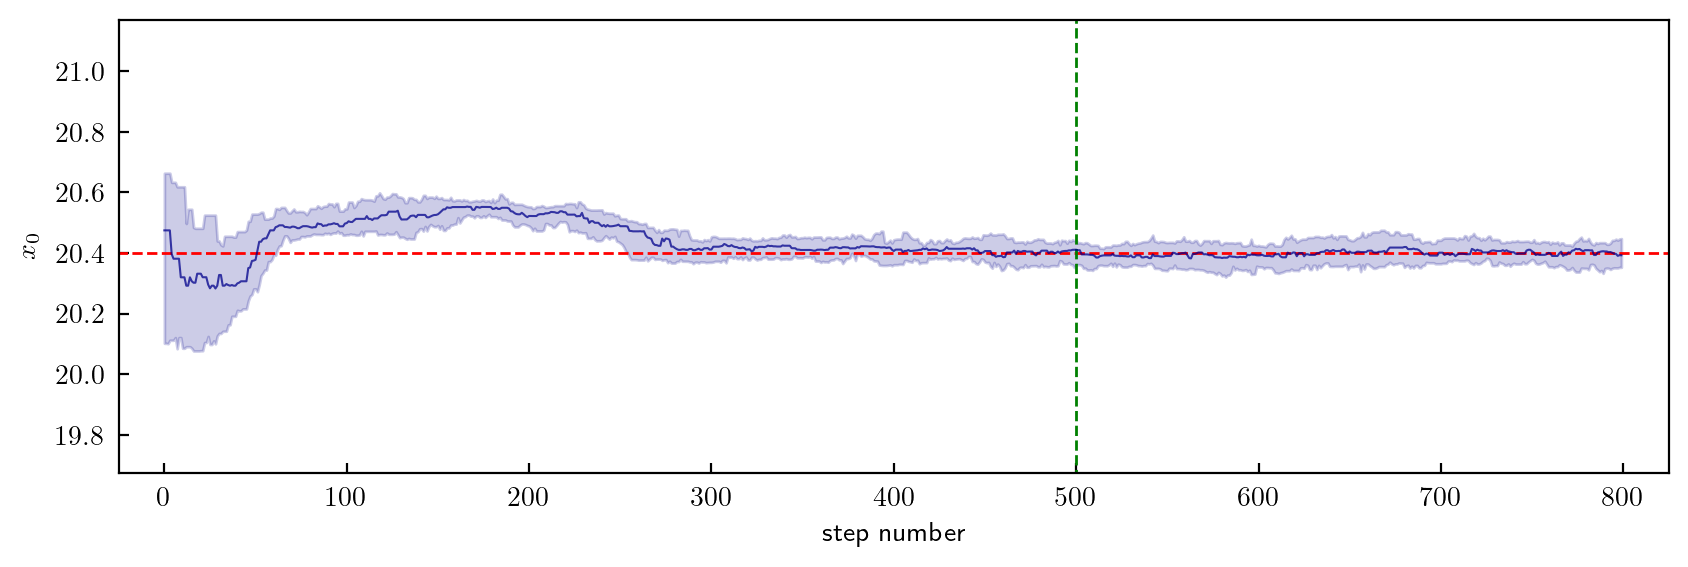

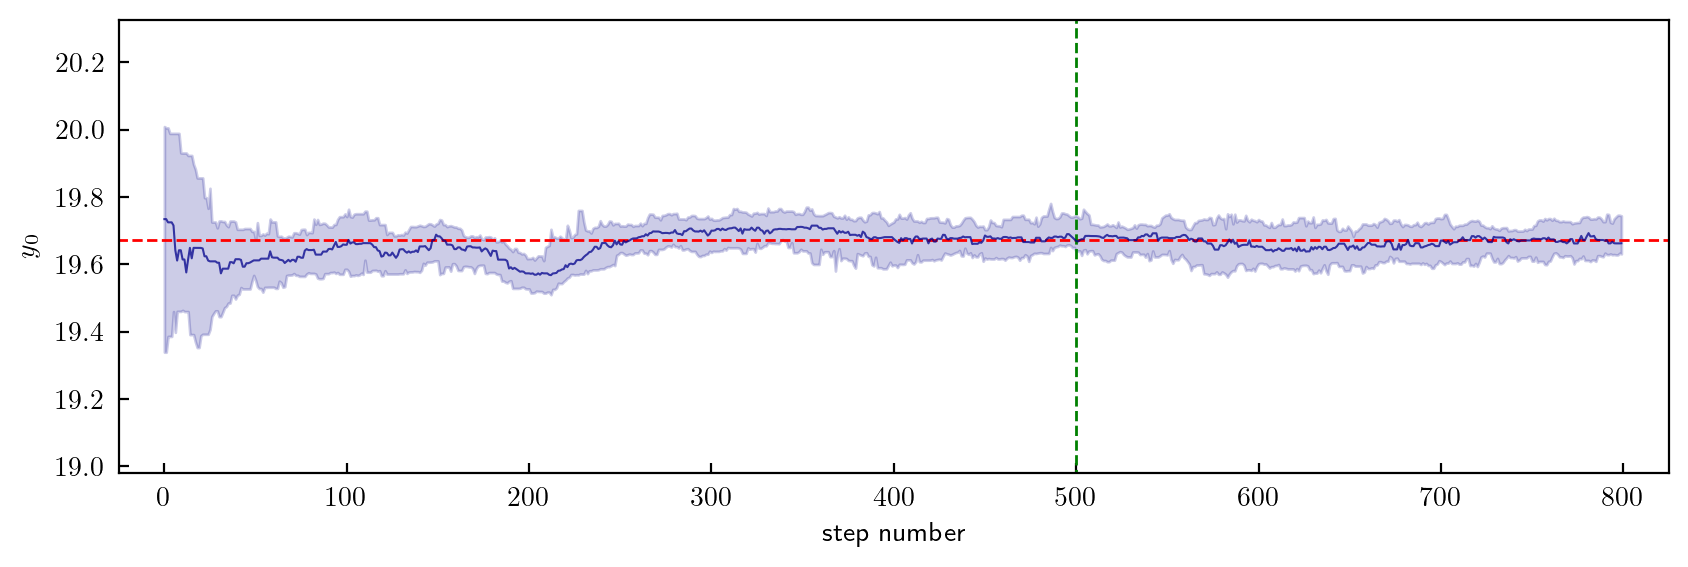

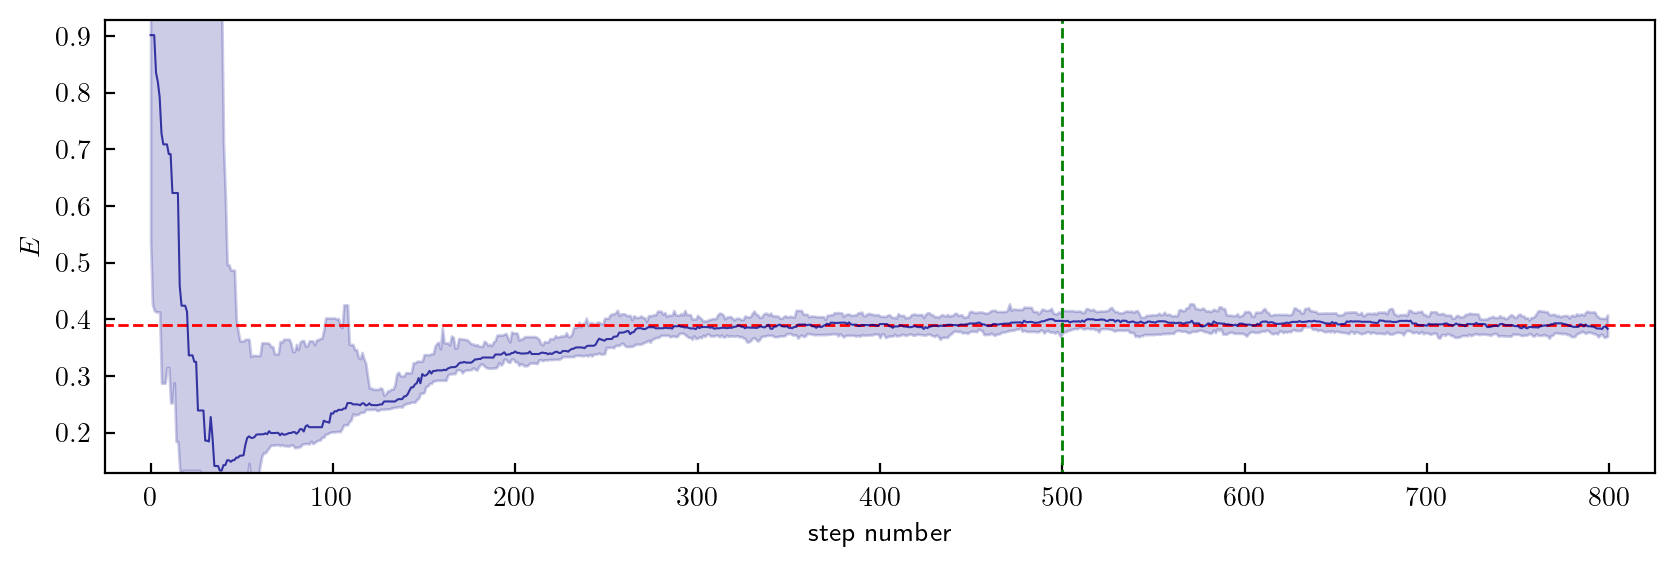

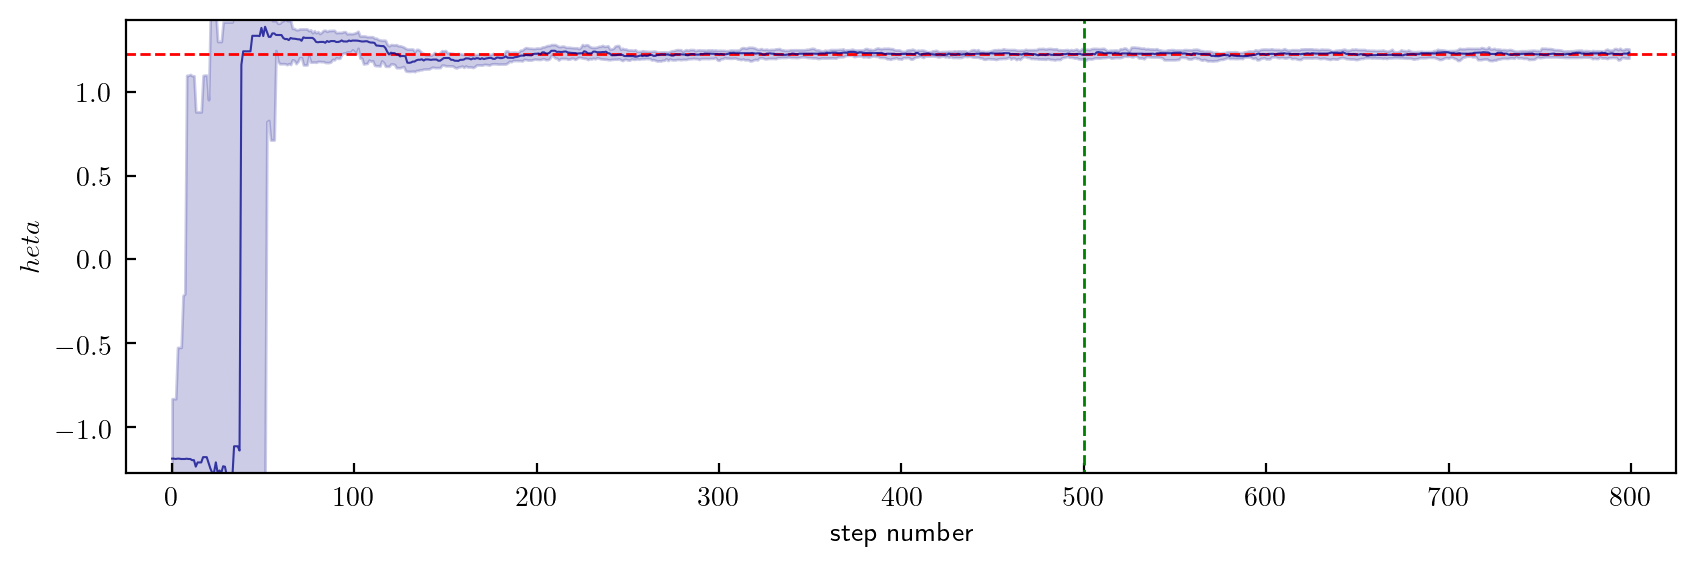

In [27]:
params = ['R_{1/2}', 'n', 'x_0', 'y_0', 'E', '\theta']

plot_trace(samples, params)

In [28]:
# MAKE THE ABOVE BOX INTO A FUNCTION

#def make_profile

from mpl_toolkits.axes_grid1 import make_axes_locatable

def plot_raw_profile_rr(profile, galaxy, stds):

    #des = bestfit_table.copy()[index]['DES_ID']
    
    diff_img = (galaxy - profile) / stds
    
    fig, ax = plt.subplots(1,3)
    fig.set_figheight(4.5)
    fig.set_figwidth(18)
    
    #fig.suptitle(des, fontsize=20)

    imgs = np.array([galaxy, profile, diff_img])
    
    imgs_min = np.min(imgs, axis=(1,2))
    imgs_max = np.max(imgs, axis=(1,2))
    
    # lower bound not 0 if negative pixel values in des images not removed
    cbar_lb = np.min(imgs_min[:2]) - 40
    cbar_ub = np.max(imgs_max[:2])

    #ax[0].set_title(r'DES redMaGiC Galaxy $I_{\rm gal}$ \nDES ID: {}'.format(des), fontsize=18)
    ax[0].set_title(r'$I_{\rm gal}$, DES ID: ' #+ des
                    , fontsize=18)
    ax[1].set_title(r'$I(\mathbf{v})$, Fitted Sérsic Profile', fontsize=18)
    ax[2].set_title(r'$\left( I_{\rm gal} - I(\mathbf{v}) \right) / \sigma$', fontsize=18)

    ax[0].set_ylabel(r'$y$', fontsize=18)
    
    for i, image in enumerate(imgs):
    
        if i == 2:
            im = ax[i].imshow(image, origin='lower', cmap='RdBu', interpolation='nearest'
                          , vmin=-5, vmax=5
                         )
            
            divider = make_axes_locatable(ax[i])
            cax = divider.append_axes('right', size='5%', pad=0.05)
            cbar = fig.colorbar(im, cax=cax)
            cbar.set_label('Residual', rotation=270, labelpad=25, fontsize=16)
        
        else:
            im = ax[i].imshow(image, origin='lower', cmap='cubehelix', interpolation='nearest'  # cmap = cubehelix, viridis
                          , vmin=cbar_lb, vmax=cbar_ub
                         )
            
            divider = make_axes_locatable(ax[i])
            cax = divider.append_axes('right', size='5%', pad=0.05)
            cbar = fig.colorbar(im, cax=cax)
            cbar.set_label('Brightness', rotation=270, labelpad=25, fontsize=16)
            
        ax[i].tick_params(axis='both', which='major', labelsize=16)
        ax[i].tick_params(axis='both', which='minor', labelsize=16)
        ax[i].set_xlabel(r'$x$', fontsize=18)

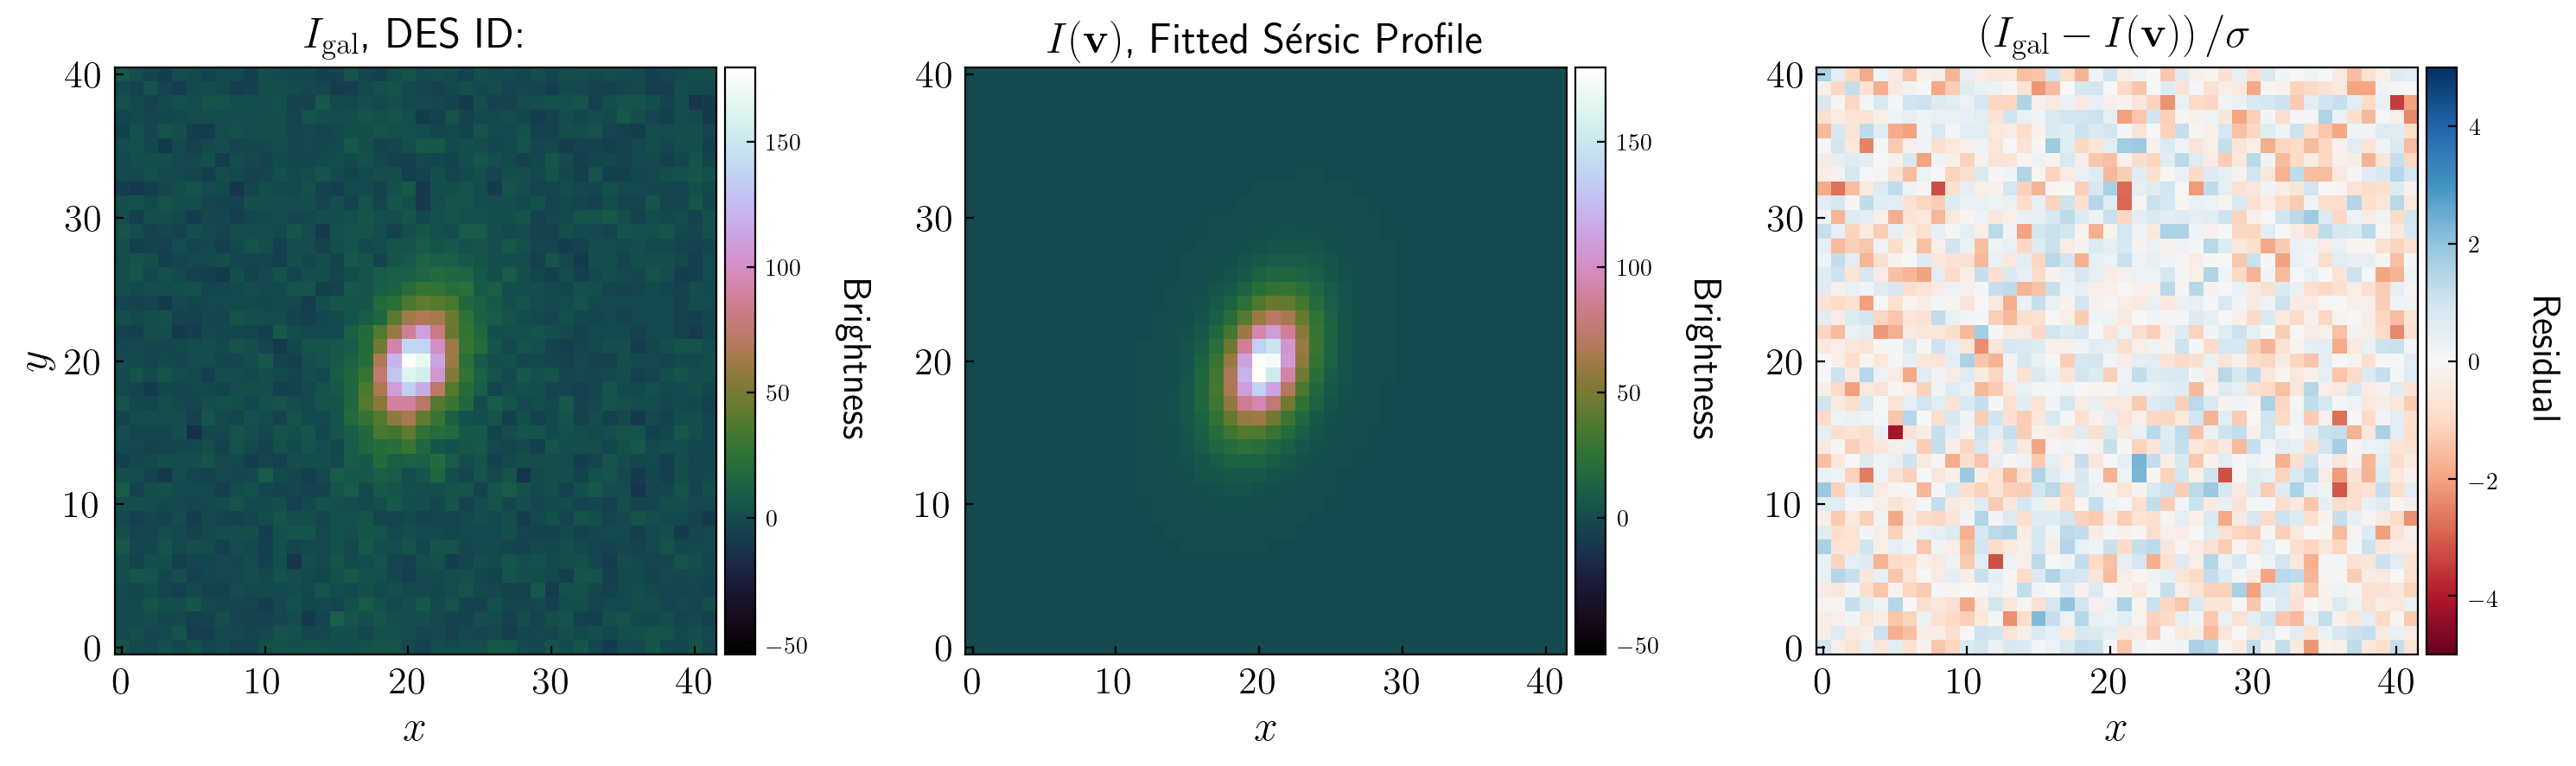

In [29]:
plot_raw_profile_rr(profile, img_gal, stds)

Text(0, 0.5, '$E_2$')

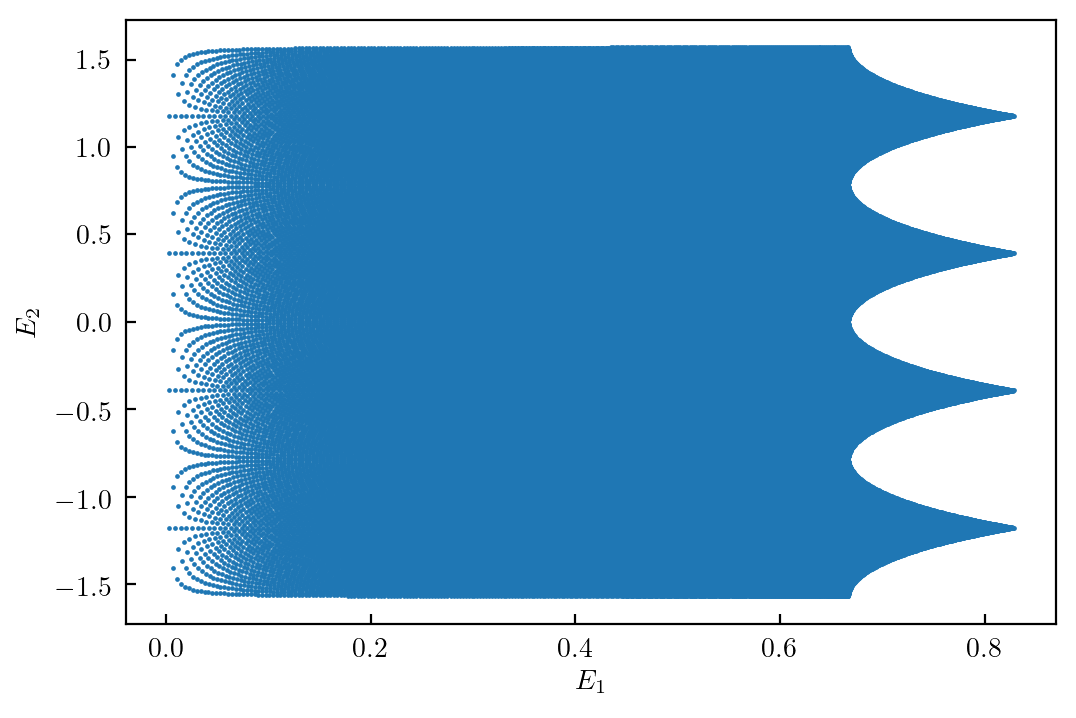

In [30]:
# me trying to figure out what limits in e and theta that e1 and e2 correspond to

e1_test = np.linspace(-0.5, 0.5, 500)
e2_test = np.linspace(-0.5, 0.5, 500)

e1_grid, e2_grid = np.meshgrid(e1_test, e2_test)

e_grid, th_grid = ellipticity2theta_q(e1_grid, e2_grid)

xvalues = np.array([0, 1, 2, 3, 4]);
yvalues = np.array([0, 1, 2, 3, 4]);

xx, yy = np.meshgrid(xvalues, yvalues)

plt.scatter(e_grid, th_grid, s=0.5)
plt.xlabel(r'$E_1$')
plt.ylabel(r'$E_2$')